In [ ]:
!python --version

Python 3.13.1


##Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, GRU, Dense, Dropout, BatchNormalization, concatenate
import tensorflow as tf

C:\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

##Load and Prepare Dataset

In [ ]:


PROCESSED_DATA_DIR = r"D:\ML Projects\RUL Prediction\Kaggle NASA data\processed_data.csv"
df = pd.read_csv(PROCESSED_DATA_DIR)
df

,capacity,discharge_time,mean_discharge_voltage,std_discharge_voltage,mean_discharge_temperature,std_discharge_temperature,mean_voltage_discharge_rate,constant_current_duration,re,rct,charge_time,mean_charge_voltage,std_charge_voltage,mean_charge_current,std_charge_current,mean_charge_temperature,std_charge_temperature,rul
0,1.674305,6436.141,3.475266,0.284626,8.272423,1.455269,0.000540,6426.781,0.054625,0.182852,10803.313,4.193521,0.054022,0.520792,0.525708,6.279191,1.080534,71
1,1.524366,5650.265,3.476559,0.272495,8.210715,1.240161,0.000615,5650.265,0.054625,0.182852,10802.078,4.187504,0.074522,0.518686,0.517950,6.414351,1.270148,70
2,1.508076,5590.907,3.470767,0.278535,7.954455,1.416882,0.000621,5590.907,0.054625,0.182852,10807.688,4.189655,0.071733,0.513528,0.513308,6.263927,1.227796,69
3,1.483558,5543.610,3.467551,0.278416,7.985865,1.378159,0.000626,5543.610,0.054625,0.182852,10805.687,4.191918,0.067646,0.507374,0.510303,6.251470,1.224826,68
4,1.467139,5499.046,3.462839,0.282585,8.009427,1.323355,0.000630,5489.671,0.054625,0.182852,10804.078,4.193113,0.065585,0.501276,0.506706,6.214979,1.348284,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2782,1.003655,2385.922,3.318070,0.373636,11.577446,3.362808,0.001391,2385.922,0.098021,0.149828,10808.032,4.200716,0.039625,0.387155,0.467983,6.159351,1.329896,4
2783,1.028527,2345.000,3.370549,0.330330,10.889278,2.661229,0.001437,2345.000,0.098021,0.149828,10803.219,4.201560,0.036670,0.372899,0.461919,6.126430,1.248580,3
2784,0.981684,2363.047,3.358032,0.355463,11.125862,3.018736,0.001421,2363.047,0.098021,0.149828,10803.406,4.201952,0.036339,0.370873,0.458506,6.082476,1.265160,2
2785,1.012712,2316.687,3.330593,0.355444,11.180258,3.021877,0.001438,2316.687,0.097744,0.153822,10802.032,4.204044,0.027451,0.377963,0.449038,5.921926,1.009685,1


In [ ]:
# If battery_id and cycle_id exist, sort them
if "battery_id" in df.columns and "cycle_id" in df.columns:
    df.sort_values(by=["battery_id", "cycle_id"], inplace=True)

In [ ]:
# Features and target
X = df.drop(columns=["rul"])  # keep battery_id/cycle_id if needed for grouping
y = df["rul"].values

In [ ]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Function to create time series sequences
def create_sequences(features, target, sequence_length=20):
    X_seq, y_seq = [], []
    for i in range(len(features) - sequence_length):
        X_seq.append(features[i:i+sequence_length])
        y_seq.append(target[i+sequence_length])
    return np.array(X_seq), np.array(y_seq)

In [ ]:
# Example: sequence length = last 20 cycles
SEQ_LEN = 20
X_seq, y_seq = create_sequences(X_scaled, y, SEQ_LEN)

In [ ]:
# Train/test split
x_train, x_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)

##EDA

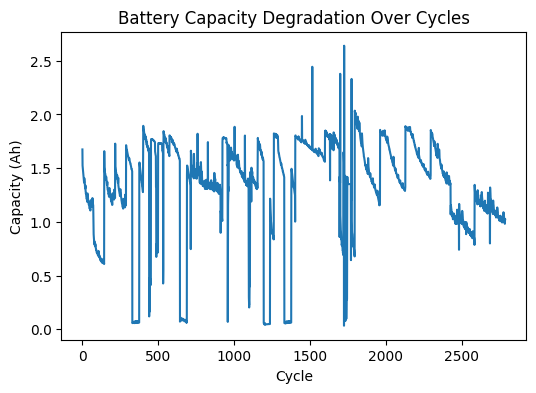

In [ ]:
import matplotlib.pyplot as plt

# 1. Capacity degradation over cycles
plt.figure(figsize=(6,4))
plt.plot(df['capacity'])
plt.xlabel("Cycle")
plt.ylabel("Capacity (Ah)")
plt.title("Battery Capacity Degradation Over Cycles")
plt.show()

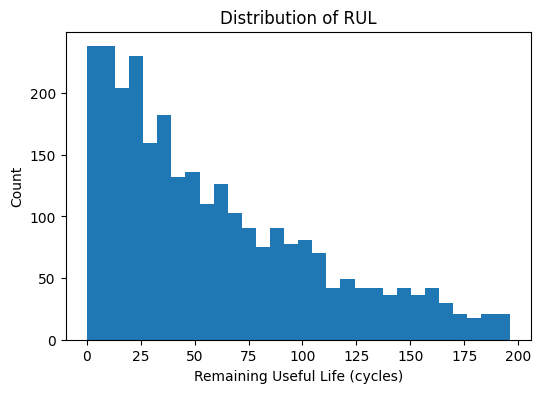

In [ ]:
# 2. Distribution of RUL
plt.figure(figsize=(6,4))
plt.hist(df['rul'], bins=30)
plt.xlabel("Remaining Useful Life (cycles)")
plt.ylabel("Count")
plt.title("Distribution of RUL")
plt.show()

In [ ]:
# Plot SOH vs SOC
plt.figure(figsize=(10, 6))
plt.scatter(x_train[:, :, 0].flatten(), y_train.flatten(), alpha=0.5, label='Training Data')
plt.scatter(x_test[:, :, 0].flatten(), y_test.flatten(), alpha=0.5, label='Testing Data')
plt.xlabel("SOC")
plt.ylabel("SOH")
plt.title("SOH vs SOC")
plt.legend()
plt.show()

##LSTM Model

###LSTM Model 1

In [ ]:
model1 = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(SEQ_LEN, X_seq.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(1)  # RUL prediction
])

model1.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
model1.summary()

C:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 20, 128)             │          74,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 20, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,225 (485.25 KB)

 Trainable params: 124,225 (485.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping callback
early = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)

# Train
history = model1.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early, plateau],
    verbose=1
)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 4906.6182 - mae: 52.0563 - val_loss: 4174.8320 - val_mae: 45.7586 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4177.0415 - mae: 46.4452 - val_loss: 3782.6938 - val_mae: 43.0875 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3820.1284 - mae: 44.1424 - val_loss: 3491.7844 - val_mae: 41.3074 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3538.6985 - mae: 42.4586 - val_loss: 3246.9980 - val_mae: 39.9713 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3299.6562 - mae: 41.0974 - val_loss: 3045.3230 - val_mae: 39.0303 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3116.1599 - mae: 40.2365 - val_loss: 2875.2083 - val_mae: 38.2174 - learning_rate: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 2927.6035 - mae: 39.0511 - val_loss: 272

In [ ]:
model1.save('D:\JN\Battery RUL Prediction\models\model1.h5')
print("Model Saved Successfully")

<>:1: SyntaxWarning: invalid escape sequence '\J'
<>:1: SyntaxWarning: invalid escape sequence '\J'
C:\Users\uneeb\AppData\Local\Temp\ipykernel_808\3618155853.py:1: SyntaxWarning: invalid escape sequence '\J'
  model1.save('D:\JN\Battery RUL Prediction\models\model1.h5')


Model Saved Successfully


In [ ]:
# Load Model
"""custom_objects = {
    "mse": MeanSquaredError(),
    "mae": MeanAbsoluteError()
}

model1 = load_model(
    r"D:\JN\Battery RUL Prediction\models\model1.h5",
    custom_objects=custom_objects
)

print("Model loaded successfully!")
model1.summary()"""


Model loaded successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 20, 128)             │          74,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,227 (485.27 KB)

 Trainable params: 124,225 (485.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

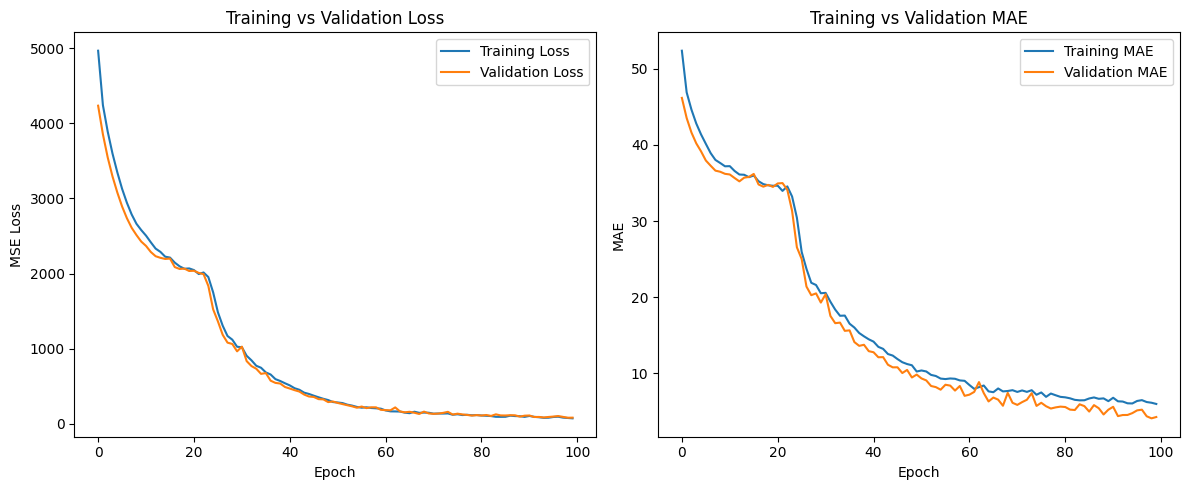

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate
loss, mae = model1.evaluate(x_test, y_test)
print(f"Test MAE: {mae:.4f}")

# Predictions
y_pred = model1.predict(x_test)

# R² Score
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 74.9422 - mae: 3.8975
Test MAE: 3.8975
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R²: 0.9676


In [ ]:
# Test vs Train Performance
y_train_pred = model1.predict(x_train).flatten()
y_test_pred = model1.predict(x_test).flatten()

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Train MAE: 2.9635, R²: 0.9861
Test MAE: 3.8975, R²: 0.9676


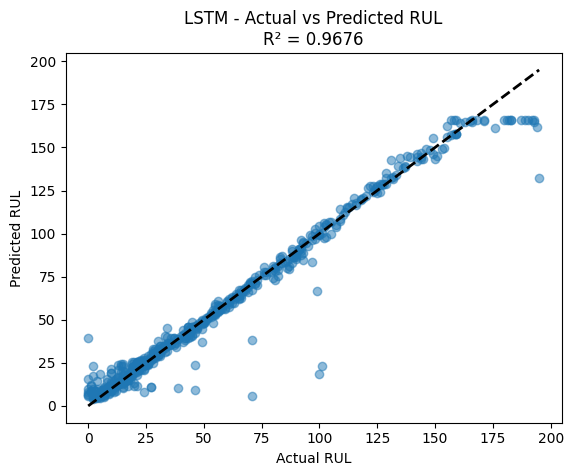

In [ ]:
# Predicted vs Actual
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"LSTM - Actual vs Predicted RUL\nR² = {r2:.4f}")
plt.show()

###LSTM Model 2

In [ ]:
model2 = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(SEQ_LEN, X_seq.shape[2])),
    #Dropout(0.2),
    Dense(64, activation='relu'),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='linear')  # RUL prediction
])

model2.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
model2.summary()

C:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 20, 128)             │          74,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,097 (453.50 KB)

 Trainable params: 116,097 (453.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Early Stopping callback
early = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)

# Train
history2 = model2.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early, plateau],
    verbose=1
)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 83.0243 - mae: 5.6698 - val_loss: 96.1112 - val_mae: 4.3215 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 69.7040 - mae: 5.3583 - val_loss: 98.1485 - val_mae: 4.4803 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 60.0075 - mae: 4.9722 - val_loss: 98.7312 - val_mae: 4.5308 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 70.8982 - mae: 5.5818 - val_loss: 90.5458 - val_mae: 4.7168 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 64.1064 - mae: 5.0160 - val_loss: 96.9423 - val_mae: 4.3989 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 62.4720 - mae: 5.0829 - val_loss: 92.9948 - val_mae: 4.0095 - learning_rate: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 56.1722 - mae: 4.8453 - val_loss: 103.6722 - val_mae: 4.7741 - learning_rate

In [ ]:
model2.save('D:\JN\Battery RUL Prediction\models\model2.h5')
print("Model Saved Successfully")

<>:1: SyntaxWarning: invalid escape sequence '\J'
<>:1: SyntaxWarning: invalid escape sequence '\J'
C:\Users\uneeb\AppData\Local\Temp\ipykernel_808\2504970943.py:1: SyntaxWarning: invalid escape sequence '\J'
  model2.save('D:\JN\Battery RUL Prediction\models\model2.h5')


Model Saved Successfully


In [ ]:
# Load Model
"""custom_objects = {
    "mse": MeanSquaredError(),
    "mae": MeanAbsoluteError()
}

model2 = load_model(
    r"D:\JN\Battery RUL Prediction\models\model2.h5",
    custom_objects=custom_objects
)

print("Model loaded successfully!")
model2.summary()"""


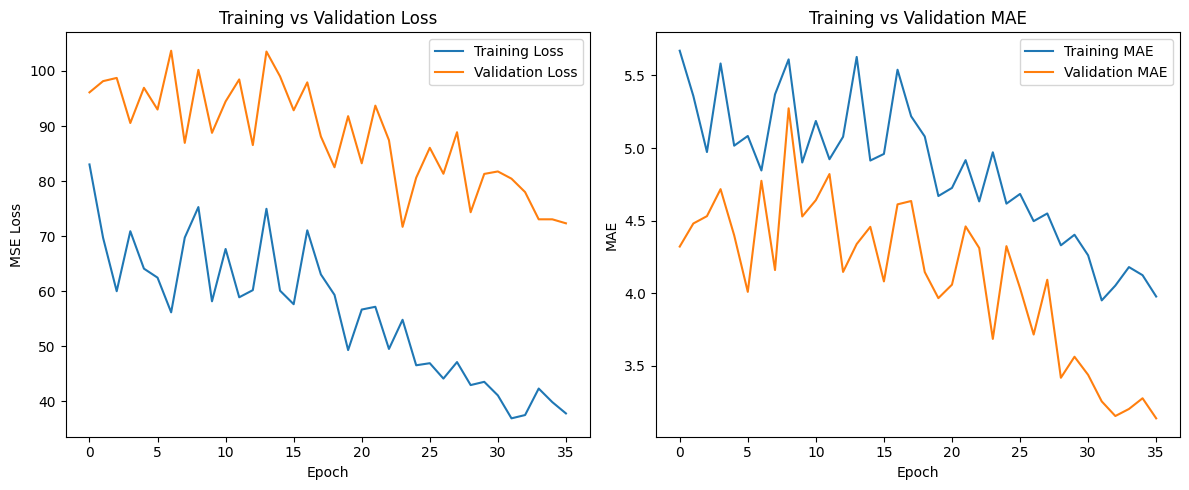

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history2.history['mae'], label='Training MAE')
plt.plot(history2.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate
loss, mae = model2.evaluate(x_test, y_test)
print(f"Test MAE: {mae:.4f}")

# Predictions
y_pred = model2.predict(x_test)

# R² Score
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 71.6960 - mae: 3.6858
Test MAE: 3.6858
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
R²: 0.9690


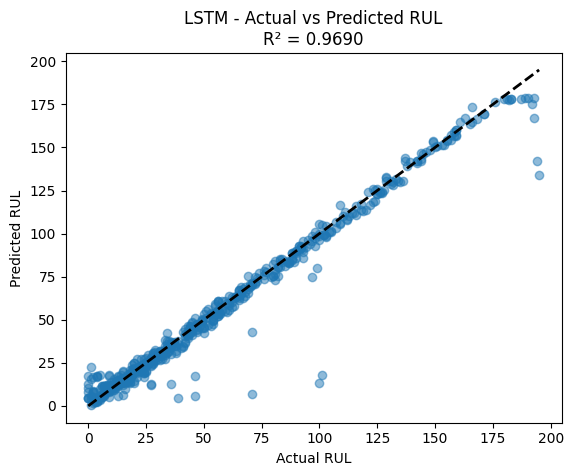

In [ ]:
# Predicted vs Actual
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"LSTM - Actual vs Predicted RUL\nR² = {r2:.4f}")
plt.show()

###LSTM Model 3

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model3 = Sequential([
    LSTM(128, activation='tanh', input_shape=(SEQ_LEN, X_seq.shape[2])),
    Dense(64, activation='relu'),
    #Dense(32, activation='relu'),
    Dense(1)
])
model3.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
model3.summary()

C:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 128)                 │          74,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,073 (324.50 KB)

 Trainable params: 83,073 (324.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping callback
early = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)

# Train
history3 = model3.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early, plateau],
    verbose=1
)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 3999.3674 - mae: 47.7049 - val_loss: 2540.6807 - val_mae: 41.2190 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2195.1531 - mae: 37.6707 - val_loss: 1917.0636 - val_mae: 34.4008 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1545.5488 - mae: 29.9458 - val_loss: 1084.9724 - val_mae: 23.9520 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 869.3292 - mae: 21.8256 - val_loss: 942.8149 - val_mae: 22.1206 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 673.0812 - mae: 18.9368 - val_loss: 663.9991 - val_mae: 17.9287 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 576.1846 - mae: 17.1128 - val_loss: 508.9829 - val_mae: 15.4153 - learning_rate: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 482.0587 - mae: 15.2545 - val_loss: 505.0714 - val

In [ ]:
model3.save('D:\JN\Battery RUL Prediction\models\model3.h5')
print("Model Saved Successfully")

In [ ]:
# Load Model
"""custom_objects = {
    "mse": MeanSquaredError(),
    "mae": MeanAbsoluteError()
}

model3 = load_model(
    r"D:\JN\Battery RUL Prediction\models\model3.h5",
    custom_objects=custom_objects
)

print("Model loaded successfully!")
model3.summary()"""


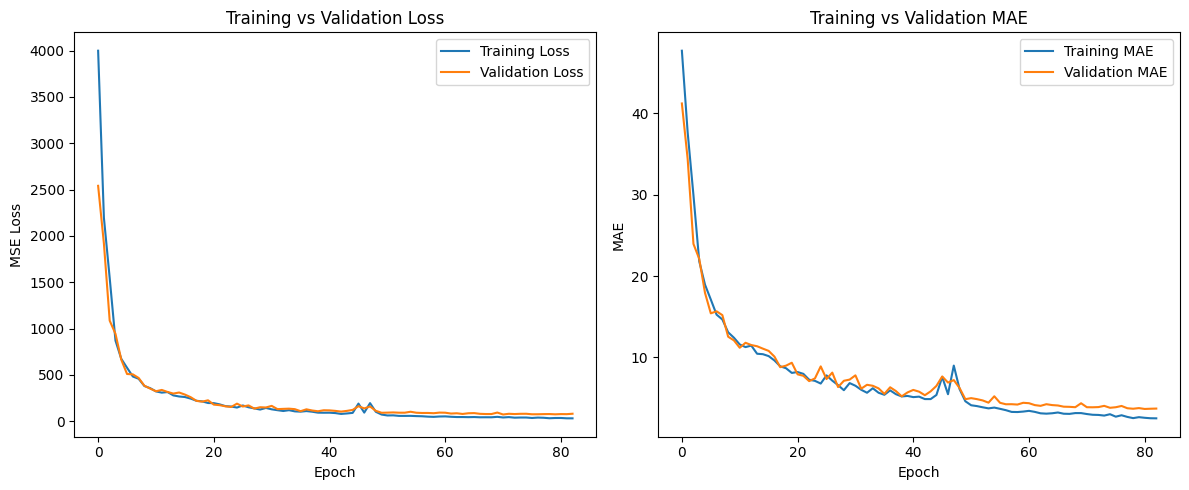

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history3.history['mae'], label='Training MAE')
plt.plot(history3.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate
loss, mae = model3.evaluate(x_test, y_test)
print(f"Test MAE: {mae:.4f}")

# Predictions
y_pred = model3.predict(x_test)

# R² Score
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 73.8686 - mae: 3.3202
Test MAE: 3.3202
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
R²: 0.9681


In [ ]:
# Test vs Train Performance
y_train_pred = model1.predict(x_train).flatten()
y_test_pred = model1.predict(x_test).flatten()

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Train MAE: 2.9635, R²: 0.9861
Test MAE: 3.8975, R²: 0.9676


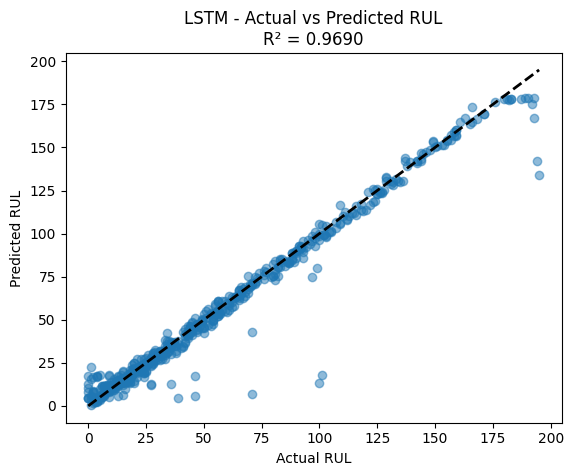

In [ ]:
# Predicted vs Actual
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"LSTM - Actual vs Predicted RUL\nR² = {r2:.4f}")
plt.show()

###LSTM Model 4

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model4 = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(SEQ_LEN, X_seq.shape[2])),
    Dense(64, activation='relu'),
    LSTM(64, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model4.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
model4.summary()

C:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 20, 128)             │          74,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 20, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,145 (461.50 KB)

 Trainable params: 118,145 (461.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping callback
early = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)

# Train
history4 = model4.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks= [early, plateau],
    verbose=1
)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 4489.3315 - mae: 48.8318 - val_loss: 2882.1235 - val_mae: 38.5597 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2506.8892 - mae: 38.6162 - val_loss: 2167.8562 - val_mae: 36.8404 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 2128.4075 - mae: 36.3666 - val_loss: 1960.2322 - val_mae: 35.2650 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1798.5568 - mae: 32.4368 - val_loss: 1295.9261 - val_mae: 26.5216 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1056.9872 - mae: 23.4459 - val_loss: 760.2706 - val_mae: 19.2290 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 674.7526 - mae: 18.3593 - val_loss: 492.4152 - val_mae: 15.6990 - learning_rate: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 517.3753 - mae: 16.0327 - val_loss: 533.491

In [ ]:
# Save Model
model4.save('D:\JN\Battery RUL Prediction\models\model4.h5')
print("Model Saved Successfully")

<>:2: SyntaxWarning: invalid escape sequence '\J'
<>:2: SyntaxWarning: invalid escape sequence '\J'
C:\Users\uneeb\AppData\Local\Temp\ipykernel_808\1854034736.py:2: SyntaxWarning: invalid escape sequence '\J'
  model4.save('D:\JN\Battery RUL Prediction\models\model4.h5')


Model Saved Successfully


In [ ]:
# Load Model
"""custom_objects = {
    "mse": MeanSquaredError(),
    "mae": MeanAbsoluteError()
}

model4 = load_model(
    r"D:\JN\Battery RUL Prediction\models\model4.h5",
    custom_objects=custom_objects
)

print("Model loaded successfully!")
model4.summary()"""

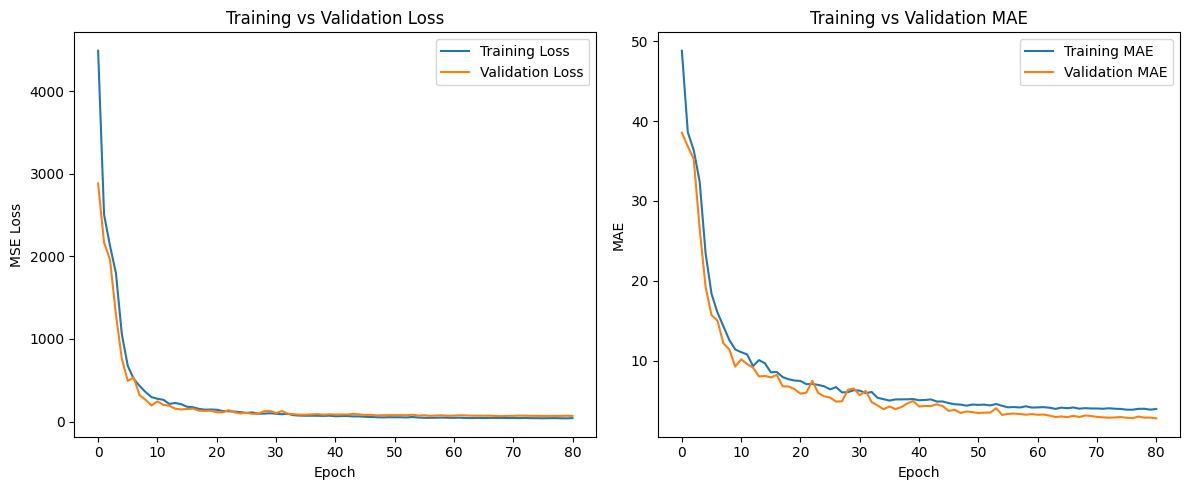

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history4.history['mae'], label='Training MAE')
plt.plot(history4.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate
loss, mae = model4.evaluate(x_test, y_test)
print(f"Test MAE: {mae:.4f}")

# Predictions
y_pred = model4.predict(x_test)

# R² Score
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 67.0045 - mae: 3.1181
Test MAE: 3.1181
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
R²: 0.9710


In [ ]:
# Test vs Train Performance
y_train_pred = model4.predict(x_train).flatten()
y_test_pred = model4.predict(x_test).flatten()

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Train MAE: 2.0655, R²: 0.9915
Test MAE: 3.1181, R²: 0.9710


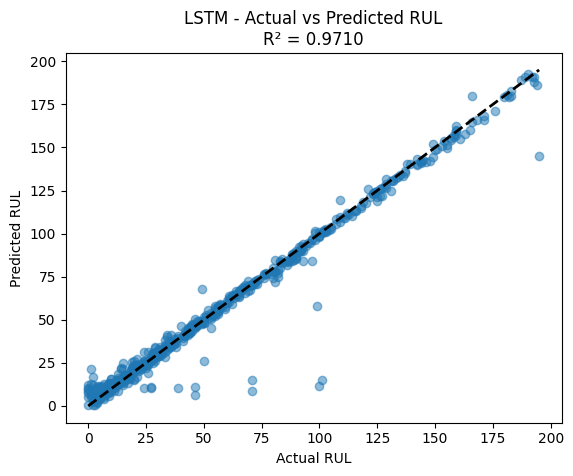

In [ ]:
# Predicted vs Actual
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"LSTM - Actual vs Predicted RUL\nR² = {r2:.4f}")
plt.show()

###LSTM Model 5

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model5 = Sequential([
    Bidirectional(LSTM(128, activation='tanh'), input_shape=(SEQ_LEN, X_seq.shape[2])),
    Dense(64, activation='relu'),
    #Dropout(0.2),
    #Dense(32, activation='relu'),
    Dense(1)
])
model5.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
model5.summary()

C:\Python313\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 256)                 │         149,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 166,017 (648.50 KB)

 Trainable params: 166,017 (648.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)


# Train
history5 = model5.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early, plateau],
    verbose=1
)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 3816.4619 - mae: 46.2534 - val_loss: 1935.0316 - val_mae: 34.7655 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1770.6929 - mae: 32.9110 - val_loss: 1529.4644 - val_mae: 30.4648 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1270.4827 - mae: 27.0114 - val_loss: 990.3506 - val_mae: 24.1328 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 841.3966 - mae: 21.5844 - val_loss: 785.4792 - val_mae: 20.7606 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 737.9922 - mae: 19.6094 - val_loss: 697.7183 - val_mae: 18.8739 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 634.5770 - mae: 17.8619 - val_loss: 622.3466 - val_mae: 17.4471 - learning_rate: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 543.8334 - mae: 16.0986 - val_loss: 529.6191 - 

In [ ]:
# Save Model
model5.save('D:\JN\Battery RUL Prediction\models\model5.h5')
print("Model Saved Successfully")

<>:2: SyntaxWarning: invalid escape sequence '\J'
<>:2: SyntaxWarning: invalid escape sequence '\J'
C:\Users\uneeb\AppData\Local\Temp\ipykernel_808\2972046368.py:2: SyntaxWarning: invalid escape sequence '\J'
  model5.save('D:\JN\Battery RUL Prediction\models\model5.h5')


Model Saved Successfully


In [ ]:
# Load Model
"""custom_objects = {
    "mse": MeanSquaredError(),
    "mae": MeanAbsoluteError()
}

model5 = load_model(
    r"D:\JN\Battery RUL Prediction\models\model5.h5",
    custom_objects=custom_objects
)

print("Model loaded successfully!")
model5.summary()"""

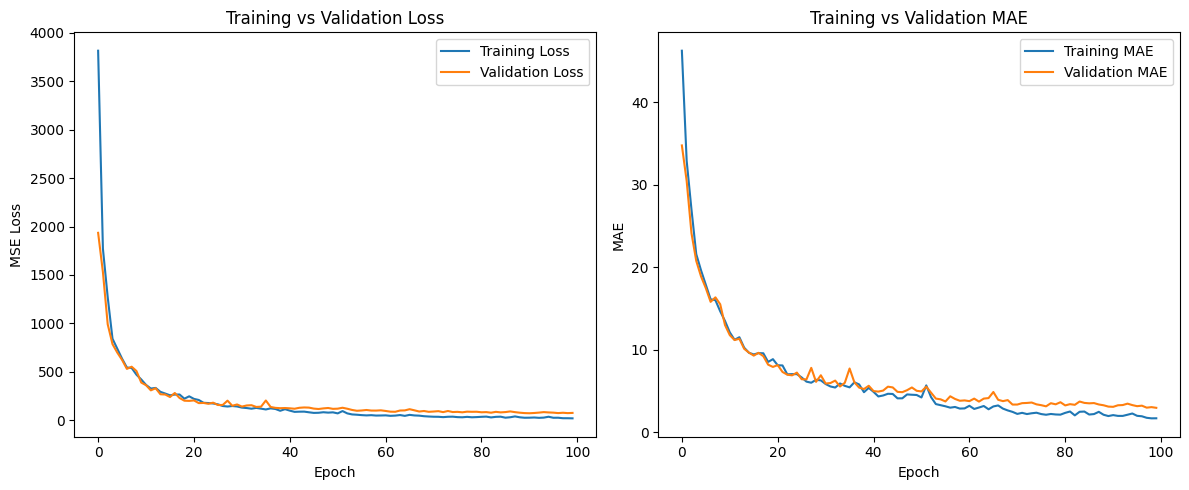

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history5.history['loss'], label='Training Loss')
plt.plot(history5.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history5.history['mae'], label='Training MAE')
plt.plot(history5.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate
loss, mae = model5.evaluate(x_test, y_test)
print(f"Test MAE: {mae:.4f}")

# Predictions
y_pred = model5.predict(x_test)

# R² Score
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 71.2741 - mae: 3.0591
Test MAE: 3.0591
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
R²: 0.9692


In [ ]:
# Test vs Train Performance
y_train_pred = model5.predict(x_train).flatten()
y_test_pred = model5.predict(x_test).flatten()

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Train MAE: 1.7386, R²: 0.9905
Test MAE: 3.0591, R²: 0.9692


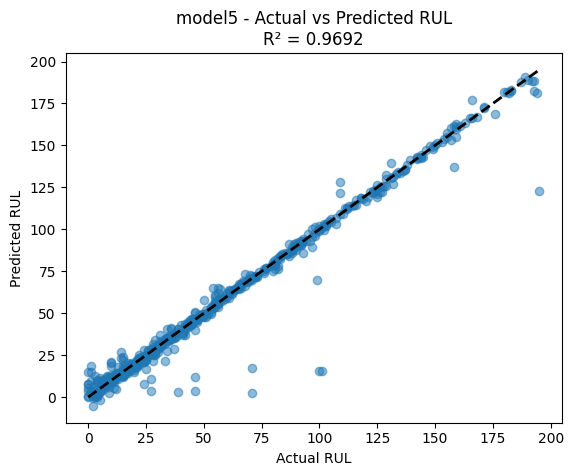

In [ ]:
# Predicted vs Actual
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"model5 - Actual vs Predicted RUL\nR² = {test_r2:.4f}")
plt.show()

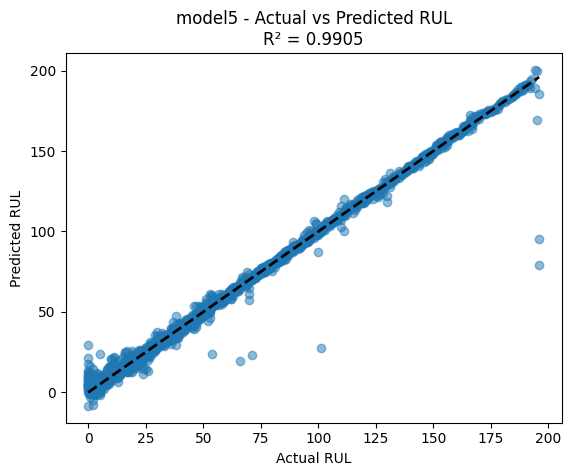

In [ ]:
# Predicted vs Actual - Train set
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"model5 - Actual vs Predicted RUL\nR² = {train_r2:.4f}")
plt.show()

###LSTM Model 6

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model6 = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(SEQ_LEN, X_seq.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(64, activation='tanh'),
    Dense(1)
])
model6.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
model6.summary()

C:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 18, 64)              │           3,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 9, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,417 (142.25 KB)

 Trainable params: 36,417 (142.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping callback
early = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)

# Train
history6 = model6.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early, plateau],
    verbose=1
)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 4985.0820 - mae: 52.3788 - val_loss: 4226.5645 - val_mae: 46.1528 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4218.0757 - mae: 46.7627 - val_loss: 3815.1814 - val_mae: 43.3036 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3840.4478 - mae: 44.2800 - val_loss: 3496.2190 - val_mae: 41.3695 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3535.1375 - mae: 42.5374 - val_loss: 3238.4985 - val_mae: 40.0052 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3286.9294 - mae: 41.2330 - val_loss: 3026.5254 - val_mae: 39.0866 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3081.0188 - mae: 40.1246 - val_loss: 2851.6558 - val_mae: 38.3288 - learning_rate: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2891.9802 - mae: 38.9111 - val_loss: 268

In [ ]:
# Save model
model6.save('D:\JN\Battery RUL Prediction\models\model6.h5')
print("Model Saved Successfully")


<>:2: SyntaxWarning: invalid escape sequence '\J'
<>:2: SyntaxWarning: invalid escape sequence '\J'
C:\Users\uneeb\AppData\Local\Temp\ipykernel_808\4119454304.py:2: SyntaxWarning: invalid escape sequence '\J'
  model6.save('D:\JN\Battery RUL Prediction\models\model6.h5')


Model Saved Successfully


In [ ]:
# Load Model
"""custom_objects = {
    "mse": MeanSquaredError(),
    "mae": MeanAbsoluteError()
}

model6 = load_model(
    r"D:\JN\Battery RUL Prediction\models\model6.h5",
    custom_objects=custom_objects
)

print("Model loaded successfully!")
model6.summary()"""

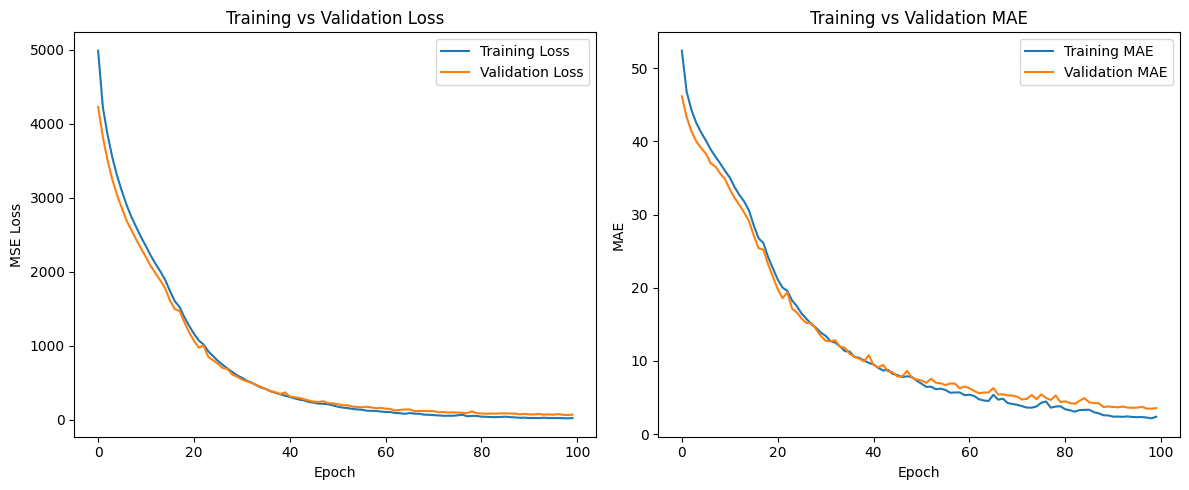

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history6.history['loss'], label='Training Loss')
plt.plot(history6.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history6.history['mae'], label='Training MAE')
plt.plot(history6.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate
loss, mae = model6.evaluate(x_test, y_test)
print(f"Test MAE: {mae:.4f}")

# Predictions
y_pred = model6.predict(x_test)

# R² Score
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 66.9403 - mae: 3.4862
Test MAE: 3.4862
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
R²: 0.9711


In [ ]:
# Test vs Train Performance
y_train_pred = model6.predict(x_train).flatten()
y_test_pred = model6.predict(x_test).flatten()

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Train MAE: 2.1389, R²: 0.9911
Test MAE: 3.4862, R²: 0.9711


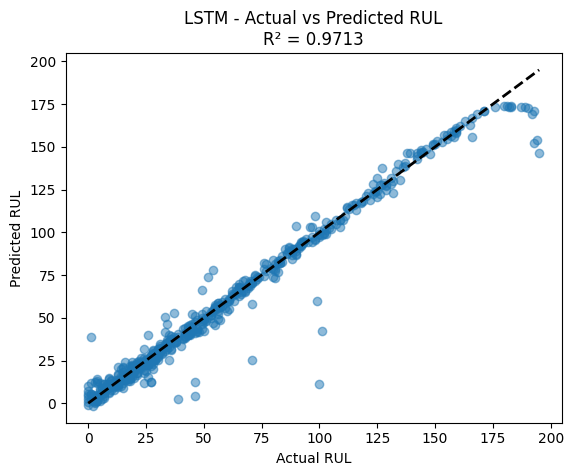

In [ ]:
# Predicted vs Actual
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"LSTM - Actual vs Predicted RUL\nR² = {r2:.4f}")
plt.show()

###LSTM Model 7

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model7 = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(SEQ_LEN, X_seq.shape[2])),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    BatchNormalization(),

    LSTM(64, activation='tanh', return_sequences=True),
    LSTM(32, activation='tanh'),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1)  # or Dense(n_classes, activation='softmax') for multiclass
])

model7.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
model7.summary()

C:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 20, 64)              │           3,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 20, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 10, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,545 (361.50 KB)

 Trainable params: 92,289 (360.50 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping callback
early = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)

# Train
history7 = model7.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early, plateau],
    verbose=1
)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 5173.6426 - mae: 54.0631 - val_loss: 3855.4250 - val_mae: 43.6841 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3182.6643 - mae: 41.0508 - val_loss: 2322.9766 - val_mae: 34.2623 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 2121.7856 - mae: 33.6233 - val_loss: 1779.8849 - val_mae: 31.1170 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1696.4067 - mae: 30.0497 - val_loss: 1669.8737 - val_mae: 30.2899 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1260.1443 - mae: 25.9044 - val_loss: 932.1112 - val_mae: 22.4350 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 788.9731 - mae: 20.0969 - val_loss: 486.3114 - val_mae: 15.4218 - learning_rate: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 634.5426 - mae: 18.0326 - val_loss: 514.20

In [ ]:
model7.save('D:\JN\Battery RUL Prediction\models\model7.h5')
print("Model Saved Successfully")


<>:1: SyntaxWarning: invalid escape sequence '\J'
<>:1: SyntaxWarning: invalid escape sequence '\J'
C:\Users\uneeb\AppData\Local\Temp\ipykernel_808\2725641712.py:1: SyntaxWarning: invalid escape sequence '\J'
  model7.save('D:\JN\Battery RUL Prediction\models\model7.h5')


Model Saved Successfully


In [ ]:
# Load Model
"""custom_objects = {
    "mse": MeanSquaredError(),
    "mae": MeanAbsoluteError()
}

model7 = load_model(
    r"D:\JN\Battery RUL Prediction\models\model7.h5",
    custom_objects=custom_objects
)

print("Model loaded successfully!")
model7.summary()"""

Model loaded successfully!


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 20, 64)              │           3,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 20, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 10, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,547 (361.52 KB)

 Trainable params: 92,289 (360.50 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 2 (12.00 B)

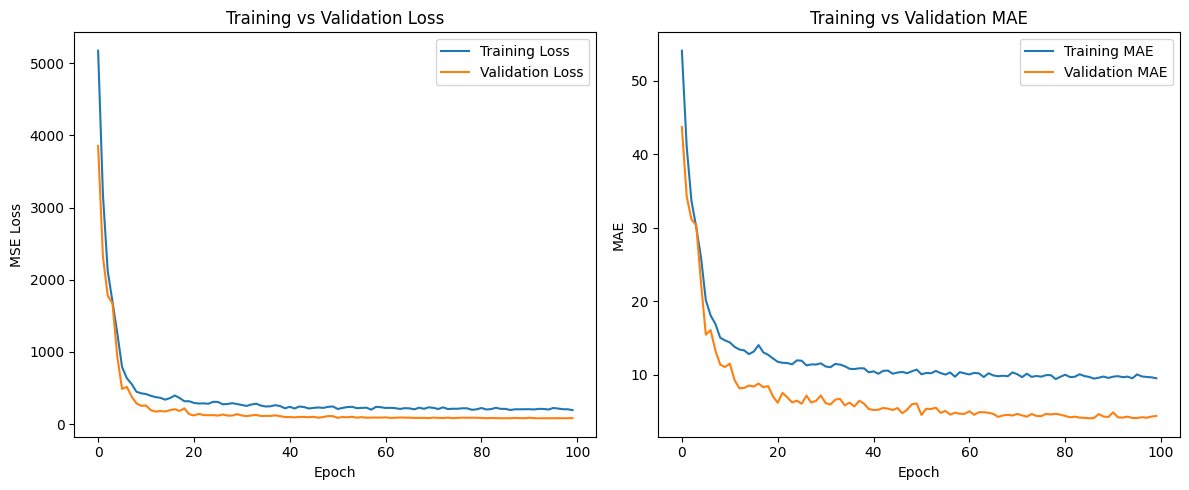

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history7.history['loss'], label='Training Loss')
plt.plot(history7.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history7.history['mae'], label='Training MAE')
plt.plot(history7.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate
loss, mae = model7.evaluate(x_test, y_test)
print(f"Test MAE: {mae:.4f}")

# Predictions
y_pred = model7.predict(x_test)

# R² Score
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 78.8191 - mae: 4.1399
Test MAE: 4.1399
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
R²: 0.9660


In [ ]:
# Test vs Train Performance
y_train_pred = model7.predict(x_train).flatten()
y_test_pred = model7.predict(x_test).flatten()

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Train MAE: 3.3506, R²: 0.9882
Test MAE: 4.1399, R²: 0.9660


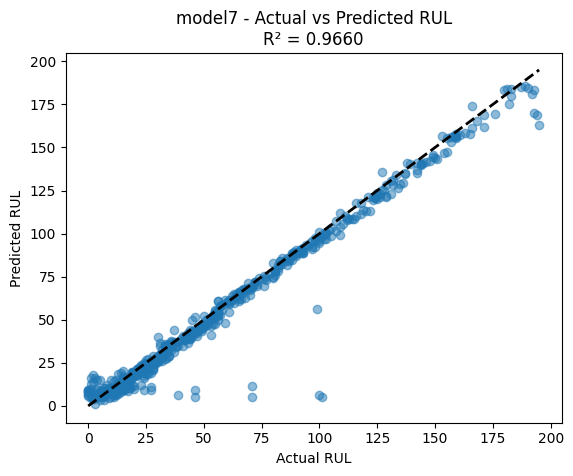

In [ ]:
# Predicted vs Actual
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"model7 - Actual vs Predicted RUL\nR² = {r2:.4f}")
plt.show()

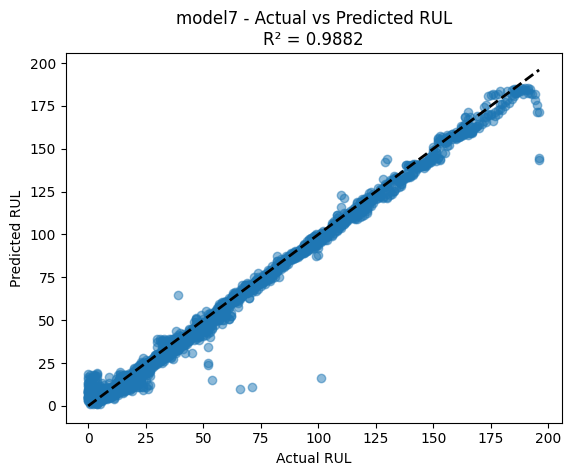

In [ ]:
# Predicted vs Actual - Train set
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"model7 - Actual vs Predicted RUL\nR² = {train_r2:.4f}")
plt.show()

###LSTM Model 8

LSTM + CNN Hybrid

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model8 = Sequential([
    Conv1D(64, 3, activation='relu', padding='same', input_shape=(SEQ_LEN, X_seq.shape[2])),
    Conv1D(128, 3, activation='relu', padding='same'),
    MaxPooling1D(2),
    Dropout(0.3),
    BatchNormalization(),

    Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
    Bidirectional(LSTM(32, activation='tanh')),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1)
])
model8.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
model8.summary()

C:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 20, 64)              │           3,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 20, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 10, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 172,801 (675.00 KB)

 Trainable params: 172,545 (674.00 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping callback
early = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)

# Train
history8 = model8.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early, plateau],
    verbose=1

)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - loss: 4200.9424 - mae: 47.7467 - val_loss: 2291.9480 - val_mae: 35.1313 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1922.6896 - mae: 32.5572 - val_loss: 1590.2972 - val_mae: 29.4843 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1216.7314 - mae: 25.3238 - val_loss: 793.2041 - val_mae: 20.4547 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 710.7812 - mae: 19.0129 - val_loss: 572.2786 - val_mae: 17.0974 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 550.0672 - mae: 16.6157 - val_loss: 432.7382 - val_mae: 15.0146 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 494.9900 - mae: 16.0655 - val_loss: 646.6580 - val_mae: 18.7724 - learning_rate: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 441.5998 - mae: 14.9591 - val_loss: 454.3428 -

In [ ]:
# Save model
model8.save('D:\JN\Battery RUL Prediction\models\model8.h5')
print("Model Saved Successfully")


<>:2: SyntaxWarning: invalid escape sequence '\J'
<>:2: SyntaxWarning: invalid escape sequence '\J'
C:\Users\uneeb\AppData\Local\Temp\ipykernel_808\3781168147.py:2: SyntaxWarning: invalid escape sequence '\J'
  model8.save('D:\JN\Battery RUL Prediction\models\model8.h5')


Model Saved Successfully


In [ ]:
# Load Model
"""custom_objects = {
    "mse": MeanSquaredError(),
    "mae": MeanAbsoluteError()
}

model8 = load_model(
    r"D:\JN\Battery RUL Prediction\models\model8.h5",
    custom_objects=custom_objects
)

print("Model loaded successfully!")
model8.summary()"""

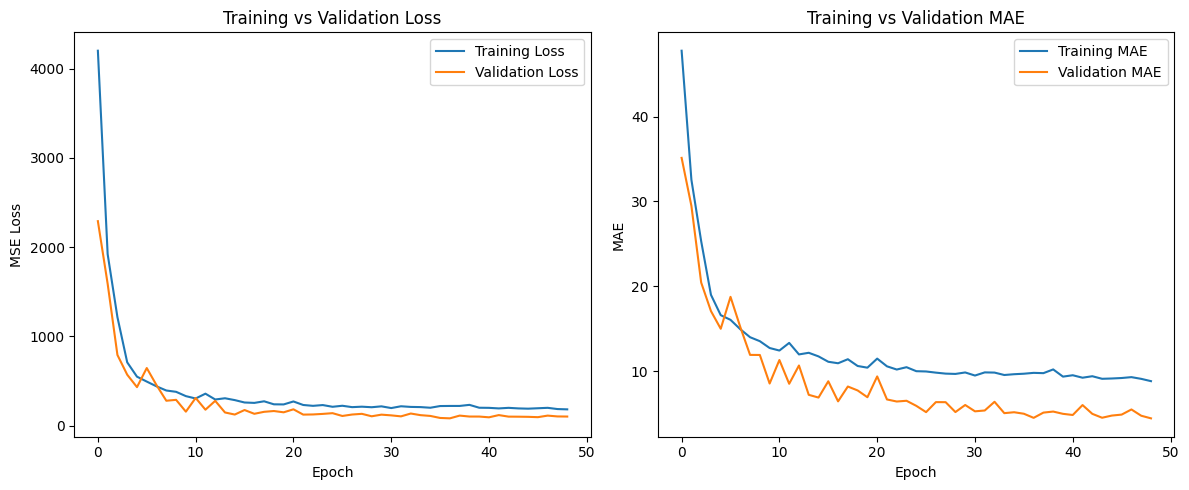

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history8.history['loss'], label='Training Loss')
plt.plot(history8.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history8.history['mae'], label='Training MAE')
plt.plot(history8.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate
loss, mae = model8.evaluate(x_test, y_test)
print(f"Test MAE: {mae:.4f}")

# Predictions
y_pred = model8.predict(x_test)

# R² Score
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 83.2500 - mae: 4.5287
Test MAE: 4.5287
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step
R²: 0.9641


In [ ]:
# Test vs Train Performance
y_train_pred = model8.predict(x_train).flatten()
y_test_pred = model8.predict(x_test).flatten()

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Train MAE: 4.0902, R²: 0.9738
Test MAE: 4.5287, R²: 0.9641


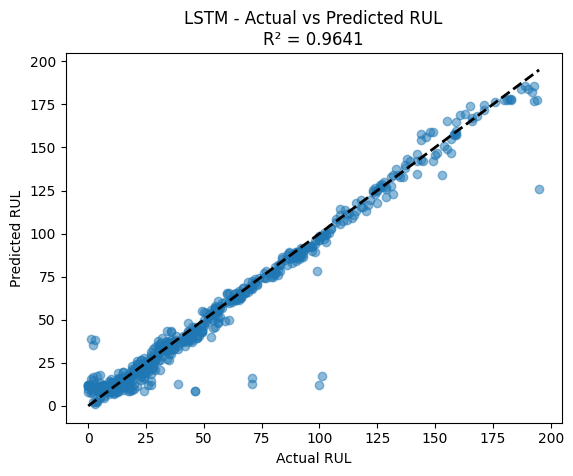

In [ ]:
# Predicted vs Actual
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"LSTM - Actual vs Predicted RUL\nR² = {r2:.4f}")
plt.show()

###Model 9

LSTM + CNN + Attention

In [ ]:
from tensorflow.keras.layers import Attention, Dense, Input, Softmax
from tensorflow.keras.models import Model

inputs = Input(shape=(SEQ_LEN, X_seq.shape[2]))
x = Conv1D(64, 3, activation='relu', padding='same')(inputs)
x = Conv1D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = LSTM(64, return_sequences=True)(x)
x = LSTM(32, return_sequences=True)(x)

# Attention
att = Dense(1, activation='tanh')(x)
att = Softmax(axis=1)(att)
x = x * att

x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
outputs = Dense(1)(x)

model9 = Model(inputs, outputs)
model9.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
model9.summary()

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)   │ (None, 20, 17)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_7 (Conv1D)             │ (None, 20, 64)            │           3,328 │ input_layer_10[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_8 (Conv1D)             │ (None, 20, 128)           │          24,704 │ conv1d_7[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_4               │ (None, 10, 128)           │               0 │ conv1d_8[0][0]             │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_12 (Dropout)          │ (None, 10, 128)           │               0 │ max_pooling1d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 10, 128)           │             512 │ dropout_12[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_17 (LSTM)                │ (None, 10, 64)            │          49,408 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_18 (LSTM)                │ (None, 10, 32)            │          12,416 │ lstm_17[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_18 (Dense)              │ (None, 10, 1)             │              33 │ lstm_18[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ softmax (Softmax)             │ (None, 10, 1)             │               0 │ dense_18[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply (Multiply)           │ (None, 10, 32)            │               0 │ lstm_18[0][0],             │
│                               │                           │                 │ softmax[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 320)               │               0 │ multiply[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_19 (Dense)              │ (None, 64)                │          20,544 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_13 (Dropout)          │ (None, 64)                │               0 │ dense_19[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_20 (Dense)              │ (None, 1)                 │              65 │ dropout_13[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 111,010 (433.63 KB)

 Trainable params: 110,754 (432.63 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)

# Train
history9 = model9.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, plateau],
    verbose=1
)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 5282.8823 - mae: 55.0939 - val_loss: 3972.3230 - val_mae: 44.7080 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3130.1821 - mae: 40.6904 - val_loss: 2345.0144 - val_mae: 36.6978 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 2272.4802 - mae: 36.1444 - val_loss: 2021.0819 - val_mae: 33.4095 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 1752.1217 - mae: 30.5403 - val_loss: 1514.2094 - val_mae: 30.0559 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 1108.8348 - mae: 23.7204 - val_loss: 785.5576 - val_mae: 19.6872 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 817.0927 - mae: 20.2216 - val_loss: 558.6313 - val_mae: 16.0402 - learning_rate: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 686.7326 - mae: 18.4821 - val_loss: 497.049

In [ ]:
# Save model
model9.save('D:\JN\Battery RUL Prediction\models\model9.h5')
print("Model Saved Successfully")

<>:2: SyntaxWarning: invalid escape sequence '\J'
<>:2: SyntaxWarning: invalid escape sequence '\J'
C:\Users\uneeb\AppData\Local\Temp\ipykernel_808\3678686497.py:2: SyntaxWarning: invalid escape sequence '\J'
  model9.save('D:\JN\Battery RUL Prediction\models\model9.h5')


Model Saved Successfully


In [ ]:
# Load Model
"""custom_objects = {
    "mse": MeanSquaredError(),
    "mae": MeanAbsoluteError()
}

model9 = load_model(
    r"D:\JN\Battery RUL Prediction\models\model9.h5",
    custom_objects=custom_objects
)

print("Model loaded successfully!")
model9.summary()"""

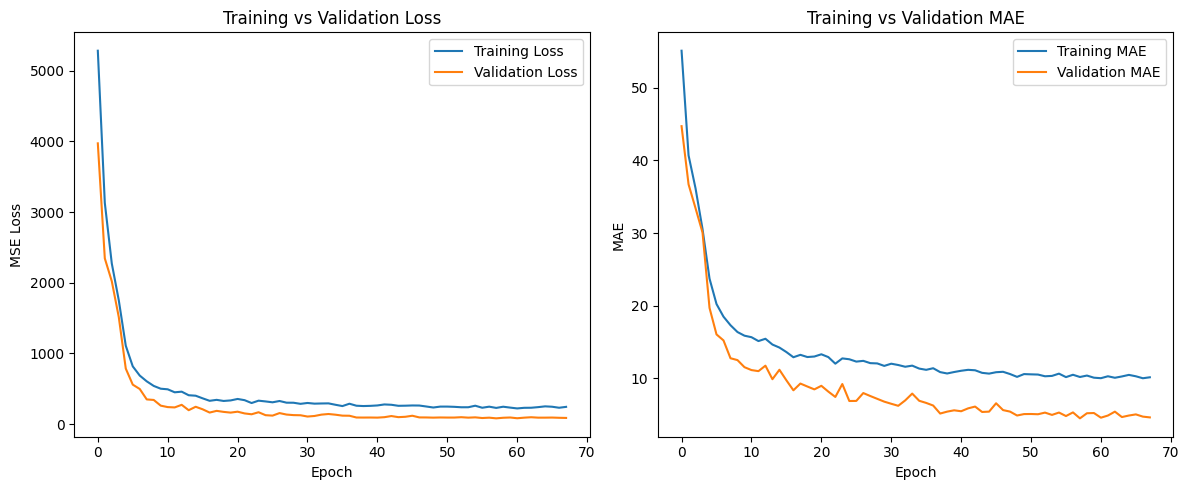

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history9.history['loss'], label='Training Loss')
plt.plot(history9.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history9.history['mae'], label='Training MAE')
plt.plot(history9.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate
loss, mae = model9.evaluate(x_test, y_test)
print(f"Test MAE: {mae:.4f}")

# Predictions
y_pred = model9.predict(x_test)

# R² Score
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 81.7427 - mae: 4.4874
Test MAE: 4.4874
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
R²: 0.9651


In [ ]:
# Test vs Train Performance
y_train_pred = model9.predict(x_train).flatten()
y_test_pred = model9.predict(x_test).flatten()

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Train MAE: 3.8822, R²: 0.9758
Test MAE: 4.4874, R²: 0.9651


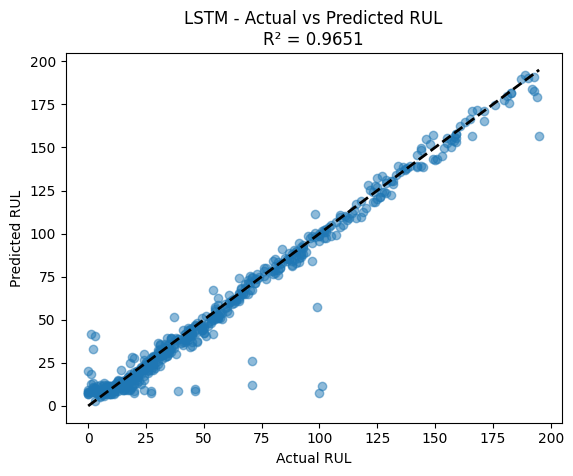

In [ ]:
# Predicted vs Actual
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"LSTM - Actual vs Predicted RUL\nR² = {r2:.4f}")
plt.show()

##GRU Models

###Model 10

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model10 = Sequential([
    GRU(64, activation='tanh', return_sequences=True, input_shape=(SEQ_LEN, X_seq.shape[2])),
    GRU(32, activation='tanh'),
    Dense(64, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1)   # regression output
])
model10.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
model10.summary()

C:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 20, 64)              │          15,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,777 (108.50 KB)

 Trainable params: 27,649 (108.00 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)

# Train
history10 = model10.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, plateau],
    verbose=1
)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 5610.6729 - mae: 59.2669 - val_loss: 5460.3979 - val_mae: 57.5310 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5013.8857 - mae: 57.8602 - val_loss: 4974.3062 - val_mae: 57.6204 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 4345.5596 - mae: 55.3902 - val_loss: 4398.3271 - val_mae: 55.9222 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3652.5371 - mae: 51.8956 - val_loss: 3260.3088 - val_mae: 49.5471 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2956.9583 - mae: 47.5108 - val_loss: 3027.4299 - val_mae: 49.4380 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2356.0938 - mae: 42.5571 - val_loss: 2559.2917 - val_mae: 46.2987 - learning_rate: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1810.3245 - mae: 37.2256 - val_loss: 140

In [ ]:
# Save model
model10.save('D:\JN\Battery RUL Prediction\models\model10.h5')
print("Model Saved Successfully")

<>:2: SyntaxWarning: invalid escape sequence '\J'
<>:2: SyntaxWarning: invalid escape sequence '\J'
C:\Users\uneeb\AppData\Local\Temp\ipykernel_808\2861365009.py:2: SyntaxWarning: invalid escape sequence '\J'
  model10.save('D:\JN\Battery RUL Prediction\models\model10.h5')


Model Saved Successfully


In [ ]:
# Load Model
"""custom_objects = {
    "mse": MeanSquaredError(),
    "mae": MeanAbsoluteError()
}

model10 = load_model(
    r"D:\JN\Battery RUL Prediction\models\model10.h5",
    custom_objects=custom_objects
)

print("Model loaded successfully!")
model10.summary()"""

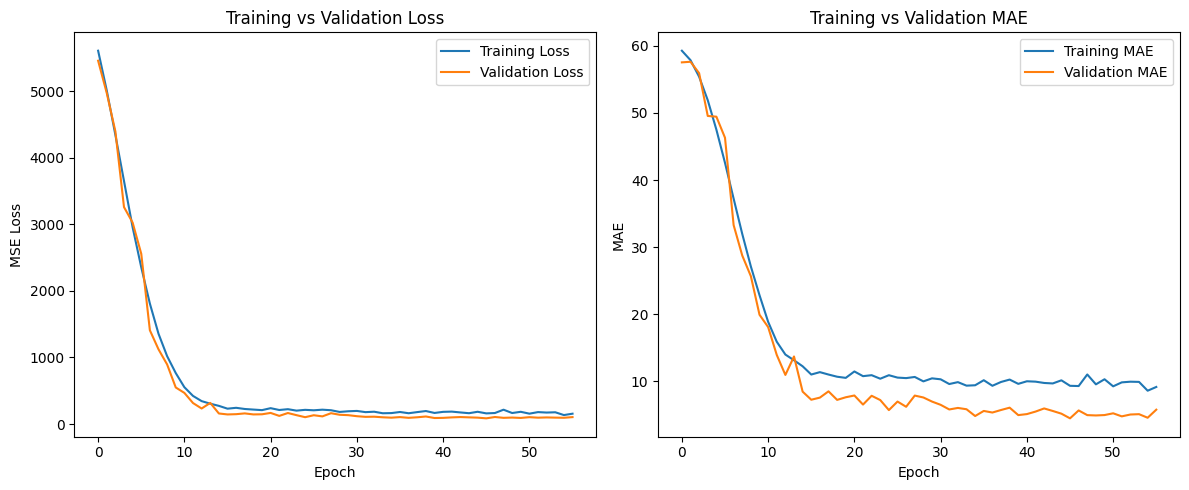

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history10.history['loss'], label='Training Loss')
plt.plot(history10.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history10.history['mae'], label='Training MAE')
plt.plot(history10.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate
loss, mae = model10.evaluate(x_test, y_test)
print(f"Test MAE: {mae:.4f}")

# Predictions
y_pred = model10.predict(x_test)

# R² Score
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 85.5632 - mae: 4.4918
Test MAE: 4.4918
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
R²: 0.9630


In [ ]:
# Test vs Train Performance
y_train_pred = model10.predict(x_train).flatten()
y_test_pred = model10.predict(x_test).flatten()

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Train MAE: 3.7390, R²: 0.9793
Test MAE: 4.4918, R²: 0.9630


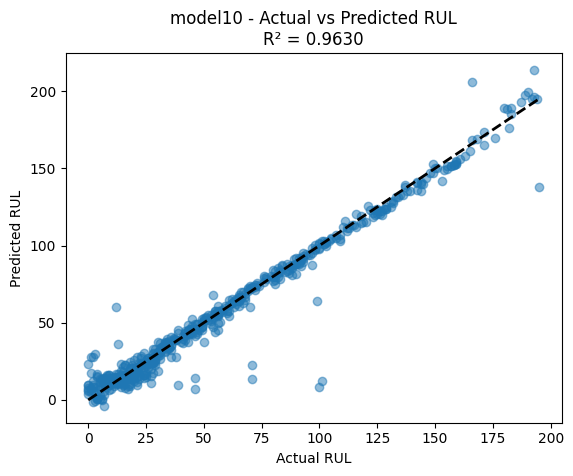

In [ ]:
# Predicted vs Actual
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"model10 - Actual vs Predicted RUL\nR² = {r2:.4f}")
plt.show()

###Model 11

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model11 = Sequential([
    GRU(128, activation='tanh', return_sequences=True, input_shape=(SEQ_LEN, X_seq.shape[2])),
    GRU(64, activation='tanh'),
    Dense(64, activation='relu'),
    Dense(1)   # regression output
])
model11.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
model11.summary()

C:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 20, 128)             │          56,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97,921 (382.50 KB)

 Trainable params: 97,921 (382.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)


# Train
history11 = model11.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early, plateau],
    verbose=1
)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 4295.0654 - mae: 48.2655 - val_loss: 2800.9121 - val_mae: 39.1972 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 2285.1890 - mae: 37.0807 - val_loss: 2180.1550 - val_mae: 38.0121 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 1908.2860 - mae: 34.7735 - val_loss: 1566.8396 - val_mae: 30.8050 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 1084.7664 - mae: 24.8147 - val_loss: 804.8294 - val_mae: 21.3380 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 633.9908 - mae: 18.8650 - val_loss: 549.9784 - val_mae: 17.8858 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 508.0624 - mae: 16.5525 - val_loss: 449.7102 - val_mae: 16.2228 - learning_rate: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 435.0099 - mae: 14.9793 - val_loss: 385.5012 

In [ ]:
# Save model
model11.save('D:\JN\Battery RUL Prediction\models\model11.h5')
print("Model Saved Successfully")


<>:2: SyntaxWarning: invalid escape sequence '\J'
<>:2: SyntaxWarning: invalid escape sequence '\J'
C:\Users\uneeb\AppData\Local\Temp\ipykernel_808\664806766.py:2: SyntaxWarning: invalid escape sequence '\J'
  model11.save('D:\JN\Battery RUL Prediction\models\model11.h5')


Model Saved Successfully


In [ ]:
# Load Model
"""custom_objects = {
    "mse": MeanSquaredError(),
    "mae": MeanAbsoluteError()
}

model11 = load_model(
    r"D:\JN\Battery RUL Prediction\models\model11.h5",
    custom_objects=custom_objects
)

print("Model loaded successfully!")
model11.summary()"""

Model loaded successfully!


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 20, 128)             │          56,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97,923 (382.52 KB)

 Trainable params: 97,921 (382.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

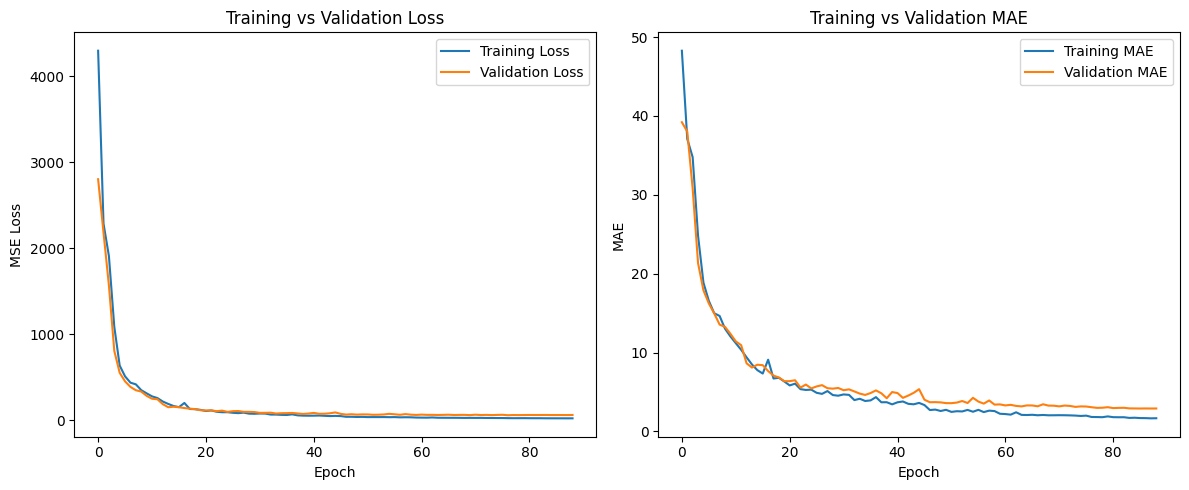

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history11.history['loss'], label='Training Loss')
plt.plot(history11.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history11.history['mae'], label='Training MAE')
plt.plot(history11.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate
loss, mae = model11.evaluate(x_test, y_test)
print(f"Test MAE: {mae:.4f}")

# Predictions
y_pred = model11.predict(x_test)

# R² Score
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 56.4122 - mae: 3.0638
Test MAE: 3.0638
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
R²: 0.9756


In [ ]:
# Test vs Train Performance
y_train_pred = model11.predict(x_train).flatten()
y_test_pred = model11.predict(x_test).flatten()

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Train MAE: 1.8286, R²: 0.9908
Test MAE: 3.0638, R²: 0.9756


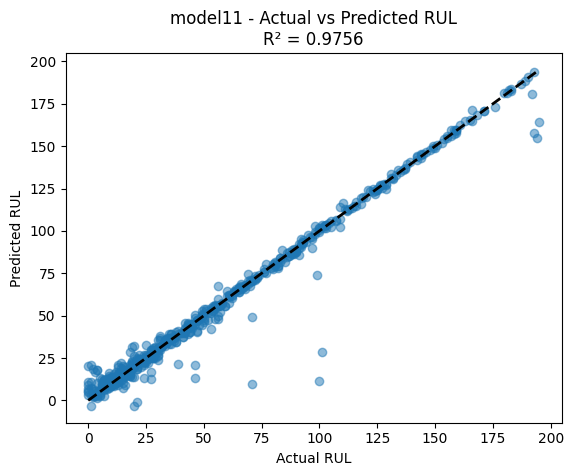

In [ ]:
# Predicted vs Actual Test set
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"model11 - Actual vs Predicted RUL\nR² = {r2:.4f}")
plt.show()

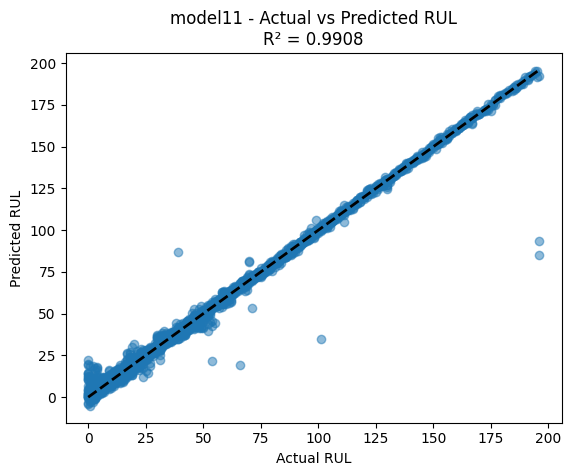

In [ ]:
# Predicted vs Actual - Train set
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"model11 - Actual vs Predicted RUL\nR² = {train_r2:.4f}")
plt.show()

###Model 12

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model12 = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(SEQ_LEN, X_seq.shape[2])),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    BatchNormalization(),

    GRU(64, activation='tanh', return_sequences=True),
    GRU(32, activation='tanh'),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1)  # or Dense(n_classes, activation='softmax') for multiclass
])

model12.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
model12.summary()

C:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)                    │ (None, 20, 64)              │           3,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 20, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 10, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 10, 64)              │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,377 (302.25 KB)

 Trainable params: 77,121 (301.25 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
history12 = model12.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32
)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 5142.9824 - mae: 54.2916 - val_loss: 4014.7937 - val_mae: 45.7358
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3463.9526 - mae: 43.1328 - val_loss: 2726.9492 - val_mae: 39.2496
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 2579.1992 - mae: 38.8759 - val_loss: 2237.0044 - val_mae: 37.1309
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 2277.8250 - mae: 37.3136 - val_loss: 2162.2380 - val_mae: 37.6085
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2219.4995 - mae: 37.2412 - val_loss: 2115.0339 - val_mae: 36.6974
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 2175.8350 - mae: 36.6137 - val_loss: 1999.5679 - val_mae: 35.5911
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1665.7823 - mae: 30.1917 - val_loss: 1244.7214 - val_mae: 25.1873
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1057.5149 - mae: 23.0904 - val_loss: 861.7938 - val_mae: 

In [ ]:
# Save model
model12.save('D:\JN\Battery RUL Prediction\models\model12.h5')
print("Model Saved Successfully")

<>:2: SyntaxWarning: invalid escape sequence '\J'
<>:2: SyntaxWarning: invalid escape sequence '\J'
C:\Users\uneeb\AppData\Local\Temp\ipykernel_808\1611683565.py:2: SyntaxWarning: invalid escape sequence '\J'
  model12.save('D:\JN\Battery RUL Prediction\models\model12.h5')


Model Saved Successfully


In [ ]:
# Load Model
"""custom_objects = {
    "mse": MeanSquaredError(),
    "mae": MeanAbsoluteError()
}

model12 = load_model(
    r"D:\JN\Battery RUL Prediction\models\model12.h5",
    custom_objects=custom_objects
)

print("Model loaded successfully!")
model12.summary()"""

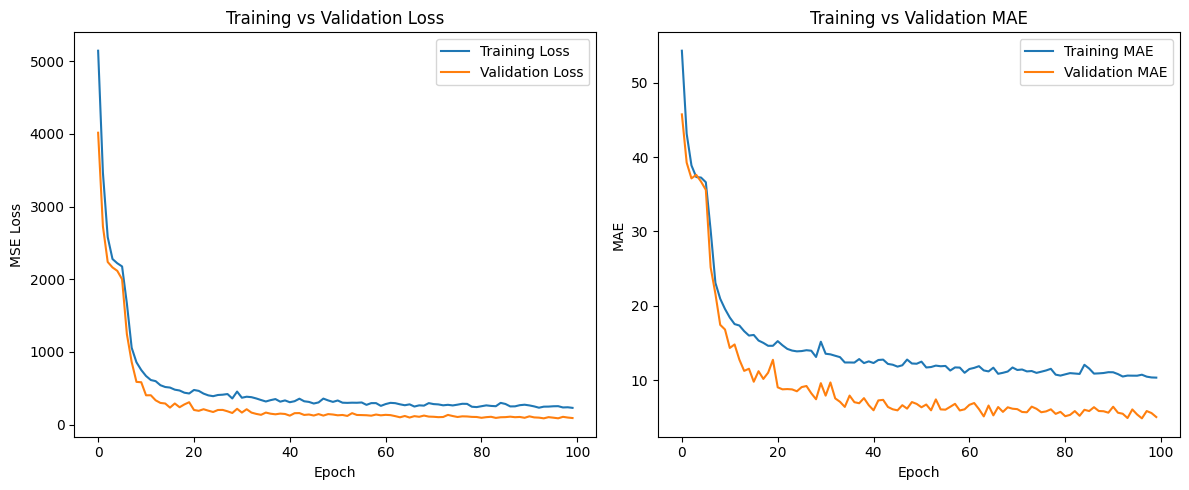

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history12.history['loss'], label='Training Loss')
plt.plot(history12.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history12.history['mae'], label='Training MAE')
plt.plot(history12.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate
loss, mae = model12.evaluate(x_test, y_test)
print(f"Test MAE: {mae:.4f}")

# Predictions
y_pred = model12.predict(x_test)

# R² Score
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 90.4662 - mae: 5.0573
Test MAE: 5.0573
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
R²: 0.9610


In [ ]:
# Test vs Train Performance
y_train_pred = model12.predict(x_train).flatten()
y_test_pred = model12.predict(x_test).flatten()

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Train MAE: 4.4354, R²: 0.9815
Test MAE: 5.0573, R²: 0.9610


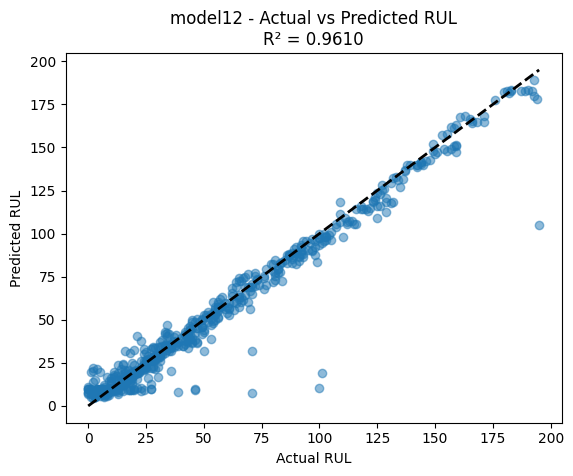

In [ ]:
# Predicted vs Actual
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"model12 - Actual vs Predicted RUL\nR² = {r2:.4f}")
plt.show()

### Model 13

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model13 = Sequential([
    Conv1D(64, kernel_size=3, activation='relu',padding='same', input_shape=(SEQ_LEN, X_seq.shape[2])),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    GRU(64, activation='tanh', return_sequences=True),
    GRU(64, activation='tanh', return_sequences=True),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.2),
    Dense(1)
])

model13.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
model13.summary()

C:\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)                   │ (None, 20, 64)              │           3,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 10, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 10, 64)              │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 10, 64)              │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 10, 64)              │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 10, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,729 (225.50 KB)

 Trainable params: 57,601 (225.00 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)

# Train
history13 = model13.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, plateau],
    verbose=1
)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 5038.5933 - mae: 53.0115 - val_loss: 3703.6348 - val_mae: 42.7213 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2970.1116 - mae: 40.4406 - val_loss: 2365.9177 - val_mae: 38.5724 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 2426.6738 - mae: 40.0409 - val_loss: 2320.4961 - val_mae: 39.6748 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 2420.3401 - mae: 40.3152 - val_loss: 2317.3877 - val_mae: 39.4783 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2420.2290 - mae: 40.1857 - val_loss: 2323.8481 - val_mae: 39.6032 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2418.7146 - mae: 40.1530 - val_loss: 2317.3870 - val_mae: 39.5389 - learning_rate: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2414.1726 - mae: 40.1978 - val_loss: 231

In [ ]:
# Save model
model13.save('D:\JN\Battery RUL Prediction\models\model13.h5')
print("Model Saved Successfully")

<>:2: SyntaxWarning: invalid escape sequence '\J'
<>:2: SyntaxWarning: invalid escape sequence '\J'
C:\Users\uneeb\AppData\Local\Temp\ipykernel_808\1533607568.py:2: SyntaxWarning: invalid escape sequence '\J'
  model13.save('D:\JN\Battery RUL Prediction\models\model13.h5')


Model Saved Successfully


In [ ]:
# Load Model
"""custom_objects = {
    "mse": MeanSquaredError(),
    "mae": MeanAbsoluteError()
}

model13 = load_model(
    r"D:\JN\Battery RUL Prediction\models\model13.h5",
    custom_objects=custom_objects
)

print("Model loaded successfully!")
model13.summary()"""

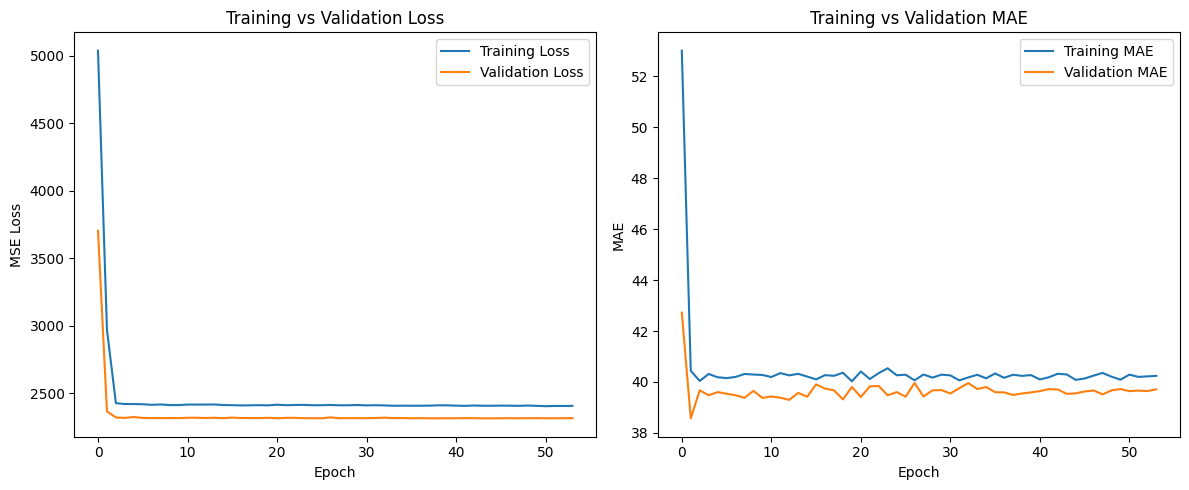

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history13.history['loss'], label='Training Loss')
plt.plot(history13.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history13.history['mae'], label='Training MAE')
plt.plot(history13.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Test vs Train Performance
y_train_pred = model13.predict(x_train).flatten()
y_test_pred = model13.predict(x_test).flatten()

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


ValueError: Found input variables with inconsistent numbers of samples: [2213, 22130]

ValueError: x and y must be the same size

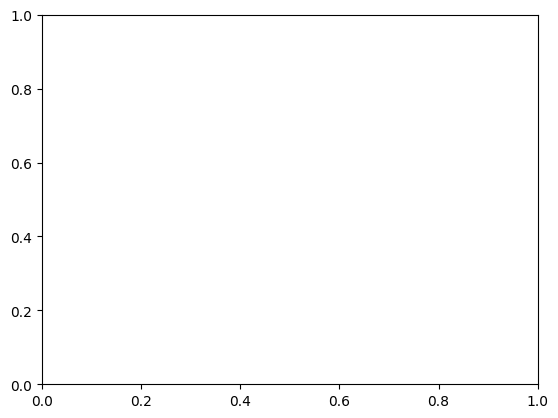

In [ ]:
# Predicted vs Actual
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"model13 - Actual vs Predicted RUL\nR² = {test_r2:.4f}")
plt.show()

###Model 14

CNN-LSTM + GRU (Ensemble Parallel Modelling)

In [ ]:
from tensorflow.keras.layers import Attention, Dense, Input, Softmax, concatenate
from tensorflow.keras.models import Model

# Define the input layer
inputs = Input(shape=(SEQ_LEN, X_seq.shape[2]))

# Branch 1: CNN + LSTM
x1 = Conv1D(64, 3, activation='relu', padding='same')(inputs)
x1 = MaxPooling1D(2)(x1)
x1 = LSTM(64, return_sequences=True)(x1)
x1 = LSTM(32)(x1)

# Branch 2: GRU
x2 = GRU(64, return_sequences=True)(inputs)
x2 = GRU(32)(x2)

# Merge branches
merged = concatenate([x1, x2])
merged = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(merged)
merged = Dropout(0.4)(merged)
merged = BatchNormalization()(merged)
outputs = Dense(1)(merged)

model14 = Model(inputs, outputs)
model14.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
model14.summary()

Model: "functional_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)   │ (None, 20, 17)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_12 (Conv1D)            │ (None, 20, 64)            │           3,328 │ input_layer_15[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_7               │ (None, 10, 64)            │               0 │ conv1d_12[0][0]            │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_19 (LSTM)                │ (None, 10, 64)            │          33,024 │ max_pooling1d_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_8 (GRU)                   │ (None, 20, 64)            │          15,936 │ input_layer_15[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_20 (LSTM)                │ (None, 32)                │          12,416 │ lstm_19[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_9 (GRU)                   │ (None, 32)                │           9,408 │ gru_8[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 64)                │               0 │ lstm_20[0][0], gru_9[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_29 (Dense)              │ (None, 64)                │           4,160 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_18 (Dropout)          │ (None, 64)                │               0 │ dense_29[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_7         │ (None, 64)                │             256 │ dropout_18[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_30 (Dense)              │ (None, 1)                 │              65 │ batch_normalization_7[0][… │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 78,593 (307.00 KB)

 Trainable params: 78,465 (306.50 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)

# Train
history14 = model14.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, plateau],
    verbose=1
)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - loss: 5568.3267 - mae: 59.2471 - val_loss: 5422.9570 - val_mae: 58.0678 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 5018.0293 - mae: 57.7894 - val_loss: 5148.3896 - val_mae: 59.1066 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 4356.5449 - mae: 55.2174 - val_loss: 4209.4106 - val_mae: 55.1462 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3703.6133 - mae: 51.5966 - val_loss: 3325.8279 - val_mae: 50.0795 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2979.3496 - mae: 47.1373 - val_loss: 2385.1045 - val_mae: 42.5824 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2288.8000 - mae: 41.9642 - val_loss: 1795.8647 - val_mae: 38.7562 - learning_rate: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1763.5461 - mae: 36.5269 - val_loss: 15

In [ ]:
# Save model
model14.save('D:\JN\Battery RUL Prediction\models\model14.h5')
print("Model Saved Successfully")


<>:2: SyntaxWarning: invalid escape sequence '\J'
<>:2: SyntaxWarning: invalid escape sequence '\J'
C:\Users\uneeb\AppData\Local\Temp\ipykernel_808\3611751592.py:2: SyntaxWarning: invalid escape sequence '\J'
  model14.save('D:\JN\Battery RUL Prediction\models\model14.h5')


Model Saved Successfully


In [ ]:
# Load Model
"""custom_objects = {
    "mse": MeanSquaredError(),
    "mae": MeanAbsoluteError()
}

model14 = load_model(
    r"D:\JN\Battery RUL Prediction\models\model14.h5",
    custom_objects=custom_objects
)

print("Model loaded successfully!")
model14.summary()"""

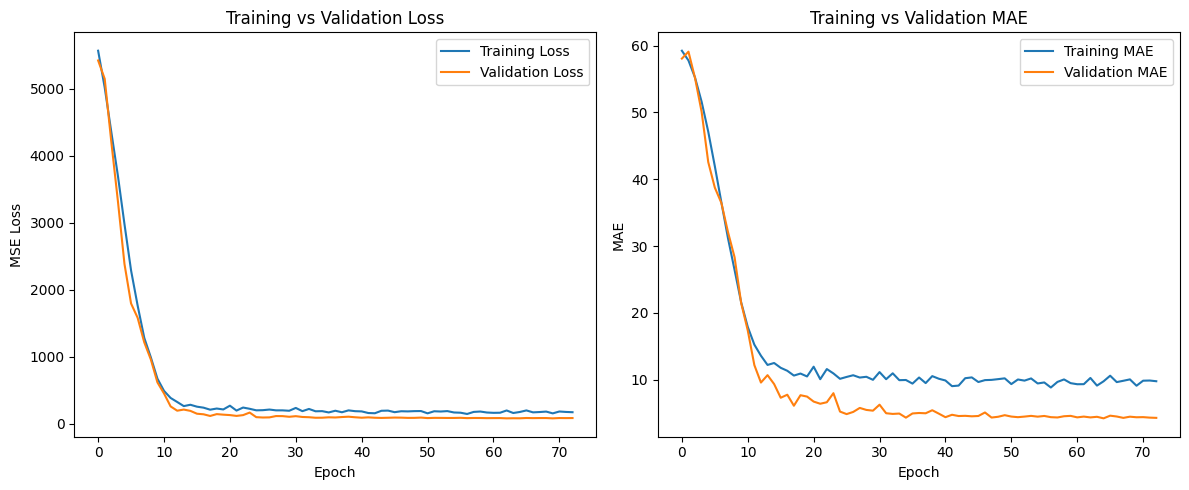

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history14.history['loss'], label='Training Loss')
plt.plot(history14.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history14.history['mae'], label='Training MAE')
plt.plot(history14.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Test vs Train Performance
y_train_pred = model14.predict(x_train).flatten()
y_test_pred = model14.predict(x_test).flatten()

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Train MAE: 3.1737, R²: 0.9852
Test MAE: 4.3558, R²: 0.9646


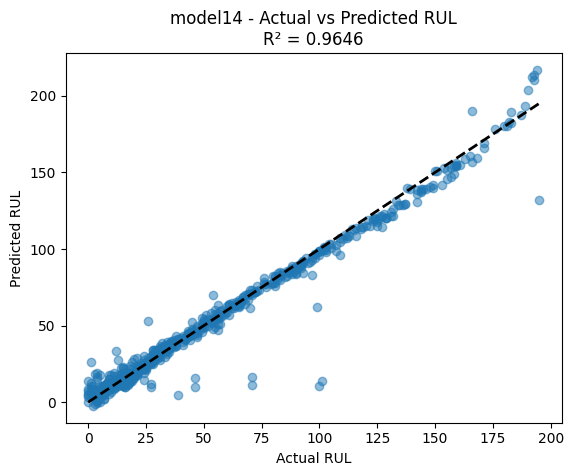

In [ ]:
# Predicted vs Actual
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"model14 - Actual vs Predicted RUL\nR² = {test_r2:.4f}")
plt.show()

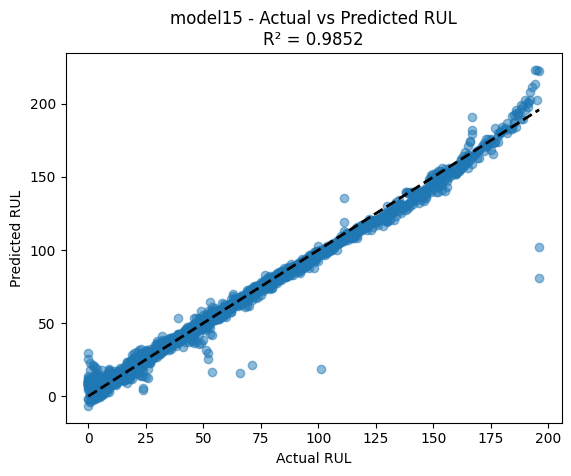

In [ ]:
# Predicted vs Actual - Train set
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"model15 - Actual vs Predicted RUL\nR² = {train_r2:.4f}")
plt.show()

###Model 15

GRU LSTM Cascade

In [ ]:
from tensorflow.keras.layers import Bidirectional

model15 = Sequential([
    GRU(64, return_sequences=True, recurrent_dropout=0.2,input_shape=(SEQ_LEN, X_seq.shape[2])),
    GRU(32, return_sequences=True, recurrent_dropout=0.2),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1)
])
model15.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])
model15.summary()

C:\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_14 (GRU)                         │ (None, 20, 64)              │          15,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_15 (GRU)                         │ (None, 20, 32)              │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,657 (213.50 KB)

 Trainable params: 54,529 (213.00 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
plateau

# Train
history15 = model15.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32
    #callbacks=[early_stopping, plateau],
    #verbose=1
)


Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 5519.7231 - mae: 59.2467 - val_loss: 5465.6382 - val_mae: 58.1872
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4929.8315 - mae: 57.7354 - val_loss: 5109.2646 - val_mae: 58.3097
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4305.1611 - mae: 55.1835 - val_loss: 4359.7695 - val_mae: 55.9723
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3632.8228 - mae: 51.5951 - val_loss: 3294.1702 - val_mae: 50.2799
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2966.9224 - mae: 47.2717 - val_loss: 2932.0740 - val_mae: 49.6010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2298.2600 - mae: 42.2138 - val_loss: 1751.8573 - val_mae: 37.1082
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1768.3649 - mae: 36.8868 - val_loss: 1759.2228 - val_mae: 37.7297
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1328.7825 - mae: 31.7319 - val_loss: 1228.2787 - val_mae: 

In [ ]:
# Save model
model15.save('D:\JN\Battery RUL Prediction\models\model15.h5')
print("Model Saved Successfully")


<>:2: SyntaxWarning: invalid escape sequence '\J'
<>:2: SyntaxWarning: invalid escape sequence '\J'
C:\Users\uneeb\AppData\Local\Temp\ipykernel_808\3000140694.py:2: SyntaxWarning: invalid escape sequence '\J'
  model15.save('D:\JN\Battery RUL Prediction\models\model15.h5')


Model Saved Successfully


In [ ]:
# Load Model
"""custom_objects = {
    "mse": MeanSquaredError(),
    "mae": MeanAbsoluteError()
}

model15 = load_model(
    r"D:\JN\Battery RUL Prediction\models\model15.h5",
    custom_objects=custom_objects
)

print("Model loaded successfully!")
model15.summary()"""

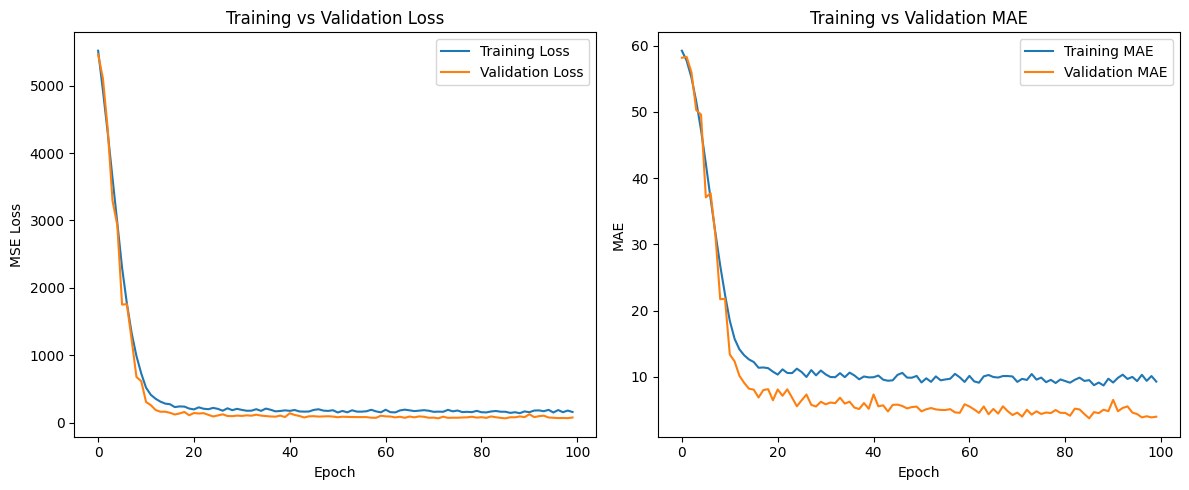

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history15.history['loss'], label='Training Loss')
plt.plot(history15.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history15.history['mae'], label='Training MAE')
plt.plot(history15.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Test vs Train Performance
y_train_pred = model15.predict(x_train).flatten()
y_test_pred = model15.predict(x_test).flatten()

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Train MAE: 3.0088, R²: 0.9874
Test MAE: 3.9944, R²: 0.9670


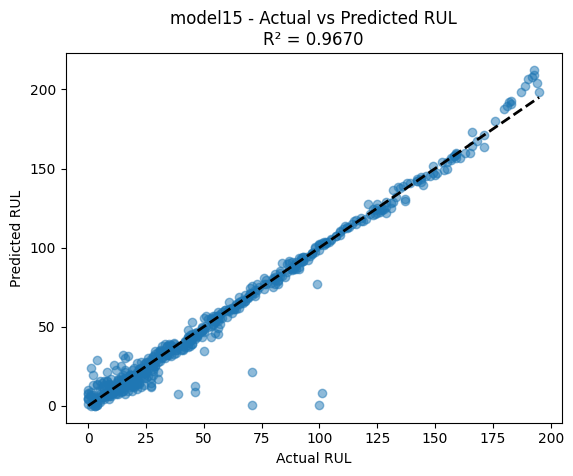

In [ ]:
# Predicted vs Actual
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"model15 - Actual vs Predicted RUL\nR² = {test_r2:.4f}")
plt.show()

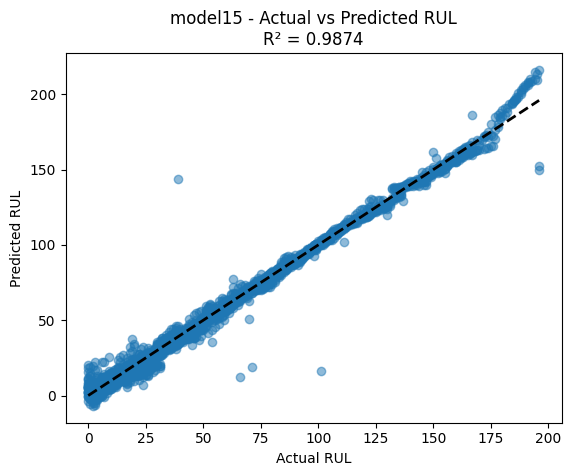

In [ ]:
# Predicted vs Actual - Train set
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"model15 - Actual vs Predicted RUL\nR² = {train_r2:.4f}")
plt.show()

##Transformer based Models

###Model 16

In [ ]:
from tensorflow.keras import layers

# ---- Positional Encoding (no class, just function) ----
def positional_encoding(seq_len, d_model):
    pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
    i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]
    angle_rates = 1.0 / tf.pow(10000.0, (2 * (i//2)) / tf.cast(d_model, tf.float32))
    angles = pos * angle_rates

    sines = tf.sin(angles[:, 0::2])
    cosines = tf.cos(angles[:, 1::2])
    pe = tf.reshape(tf.stack([sines, cosines], axis=-1), (seq_len, -1))[:, :d_model]
    return pe  # (seq_len, d_model)

# ---- Transformer block (functional) ----
def transformer_block(x, d_model, num_heads, ff_dim, dropout):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout)(x, x)
    attn = layers.Dropout(dropout)(attn)
    out1 = layers.LayerNormalization(epsilon=1e-6)(x + attn)

    ffn = layers.Dense(ff_dim, activation="relu")(out1)
    ffn = layers.Dense(d_model)(ffn)
    ffn = layers.Dropout(dropout)(ffn)
    return layers.LayerNormalization(epsilon=1e-6)(out1 + ffn)

# ---- Build model16 without classes ----
def build_model16(seq_len, n_features,
                  d_model=128, num_heads=4, ff_dim=256,
                  num_layers=2, dropout=0.2, mlp_units=64, lr=1e-3):

    inputs = layers.Input(shape=(seq_len, n_features))

    # project input to d_model
    x = layers.Dense(d_model)(inputs)

    # add positional encoding (via Lambda)
    pe = positional_encoding(seq_len, d_model)
    # Specify output_shape for the Lambda layer
    x = layers.Lambda(lambda z: z + pe, output_shape=(seq_len, d_model))(x)

    # stack transformer blocks
    for _ in range(num_layers):
        x = transformer_block(x, d_model, num_heads, ff_dim, dropout)

    # pooling
    x_mean = layers.GlobalAveragePooling1D()(x)
    x_max = layers.GlobalMaxPooling1D()(x)
    x = layers.Concatenate()([x_mean, x_max])

    # dense head
    x = layers.Dense(mlp_units, activation="relu",
                     kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(1)(x)

    model = Model(inputs, outputs, name="Transformer_RUL_model16")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss="mse", metrics=["mae"])
    return model

In [ ]:
model16 = build_model16(
    seq_len=SEQ_LEN,
    n_features=X_seq.shape[2],
    d_model=64,        # try {64, 128, 256}
    num_heads=4,        # try {2, 4, 8} (must divide d_model)
    ff_dim=256,         # try {128, 256, 512}
    num_layers=2,       # try {2, 3, 4}
    dropout=0.2,        # try {0.1 - 0.4}
    mlp_units=64,       # try {64, 128}
    lr=1e-3             # try 1e-3 then ReduceLROnPlateau
)
model16.summary()

Model: "Transformer_RUL_model16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)   │ (None, 20, 17)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_37 (Dense)              │ (None, 20, 64)            │           1,152 │ input_layer_19[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda (Lambda)               │ (None, 20, 64)            │               0 │ dense_37[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 20, 64)            │          66,368 │ lambda[0][0], lambda[0][0] │
│ (MultiHeadAttention)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_23 (Dropout)          │ (None, 20, 64)            │               0 │ multi_head_attention[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 20, 64)            │               0 │ lambda[0][0],              │
│                               │                           │                 │ dropout_23[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 20, 64)            │             128 │ add[0][0]                  │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_38 (Dense)              │ (None, 20, 256)           │          16,640 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_39 (Dense)              │ (None, 20, 64)            │          16,448 │ dense_38[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_24 (Dropout)          │ (None, 20, 64)            │               0 │ dense_39[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 20, 64)            │               0 │ layer_normalization[0][0], │
│                               │                           │                 │ dropout_24[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 20, 64)            │             128 │ add_1[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 20, 64)            │          66,368 │ layer_normalization_1[0][… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_26 (Dropout)          │ (None, 20, 64)            │               0 │ multi_head_attention_1[0]… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 209,153 (817.00 KB)

 Trainable params: 209,025 (816.50 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)


# Train
history16 = model16.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early, plateau],
    verbose=1
)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 5466.3081 - mae: 59.2281 - val_loss: 4964.9297 - val_mae: 59.1988 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 4785.1147 - mae: 57.6717 - val_loss: 4167.9131 - val_mae: 54.8389 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 4168.2998 - mae: 55.1223 - val_loss: 3768.9978 - val_mae: 55.0757 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3506.5535 - mae: 51.5350 - val_loss: 3568.8884 - val_mae: 55.3833 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 2853.7368 - mae: 47.1870 - val_loss: 2955.8784 - val_mae: 50.8301 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2255.4402 - mae: 42.2630 - val_loss: 4249.4888 - val_mae: 58.4223 - learning_rate: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1872.0607 - mae: 37.3269 - val_loss: 243

In [ ]:
# Save model
model16.save(r'D:\JN\Battery RUL Prediction\models\model16.keras')
print("Model Saved Successfully")


Model Saved Successfully


In [ ]:
# Load Model
custom_objects = {
    "mse": MeanSquaredError(),
    "mae": MeanAbsoluteError()
}

model16 = load_model(
    r"D:\JN\Battery RUL Prediction\models\model16.keras",
    custom_objects=custom_objects,
    safe_mode=False
)

print("Model loaded successfully!")
model16.summary()

NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=('<KerasTensor shape=(None, 20, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_290>',)
  • kwargs={'mask': 'None'}

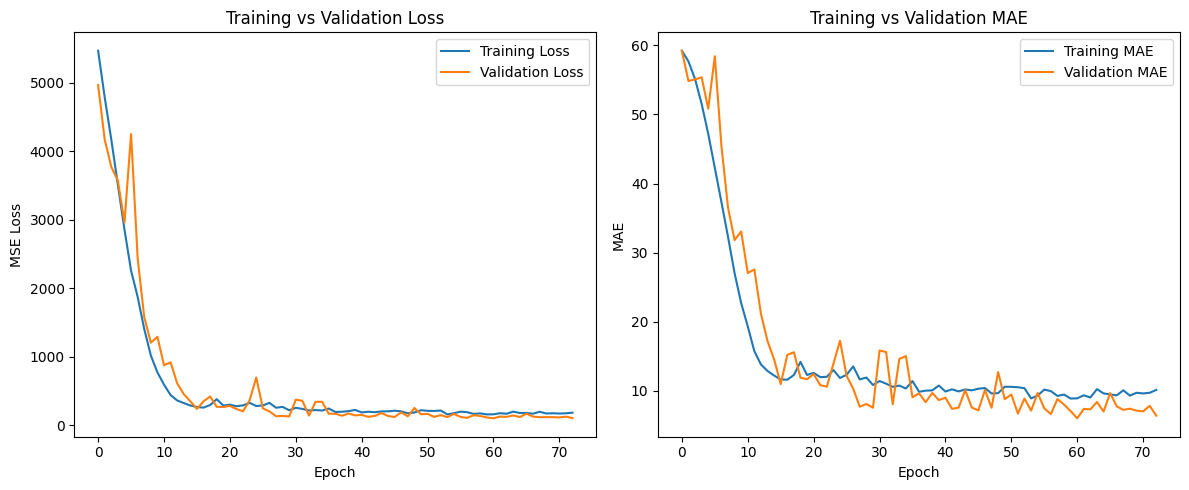

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history16.history['loss'], label='Training Loss')
plt.plot(history16.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history16.history['mae'], label='Training MAE')
plt.plot(history16.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Test vs Train Performance
y_train_pred = model16.predict(x_train).flatten()
y_test_pred = model16.predict(x_test).flatten()

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Train MAE: 5.8317, R²: 0.9671
Test MAE: 5.9996, R²: 0.9576


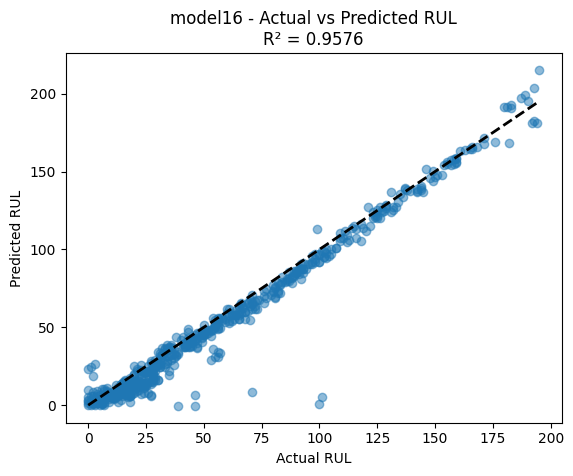

In [ ]:
# Predicted vs Actual
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"model16 - Actual vs Predicted RUL\nR² = {test_r2:.4f}")
plt.show()

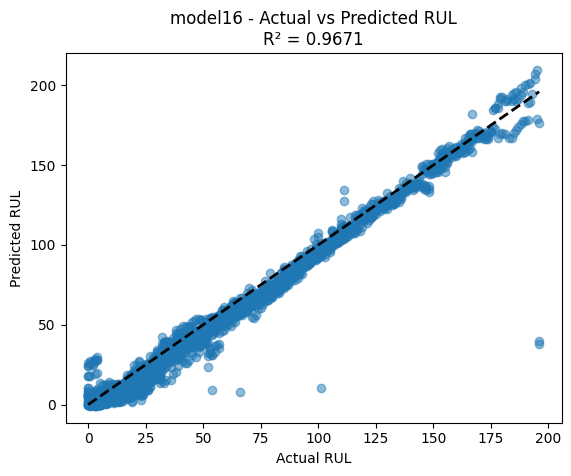

In [ ]:
# Predicted vs Actual - Train set
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()],
         'k--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"model16 - Actual vs Predicted RUL\nR² = {train_r2:.4f}")
plt.show()

# Forecasting

In [ ]:
def forecast_rul(model, x_test, y_test, title):
    """
    Forecasts Battery RUL using the given model and plots the results.

    Args:
        model: The trained Keras model for RUL prediction.
        x_test: The test data (features).
        y_test: The true RUL values for the test data.
        title: The title for the plot.
    """
    y_pred = model.predict(x_test).flatten()

    plt.figure(figsize=(15, 9))
    plt.plot(y_test, label='Actual RUL')
    plt.plot(y_pred, label='Predicted RUL')
    plt.title(f'{title} - Battery RUL Forecast')
    plt.xlabel('Time')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


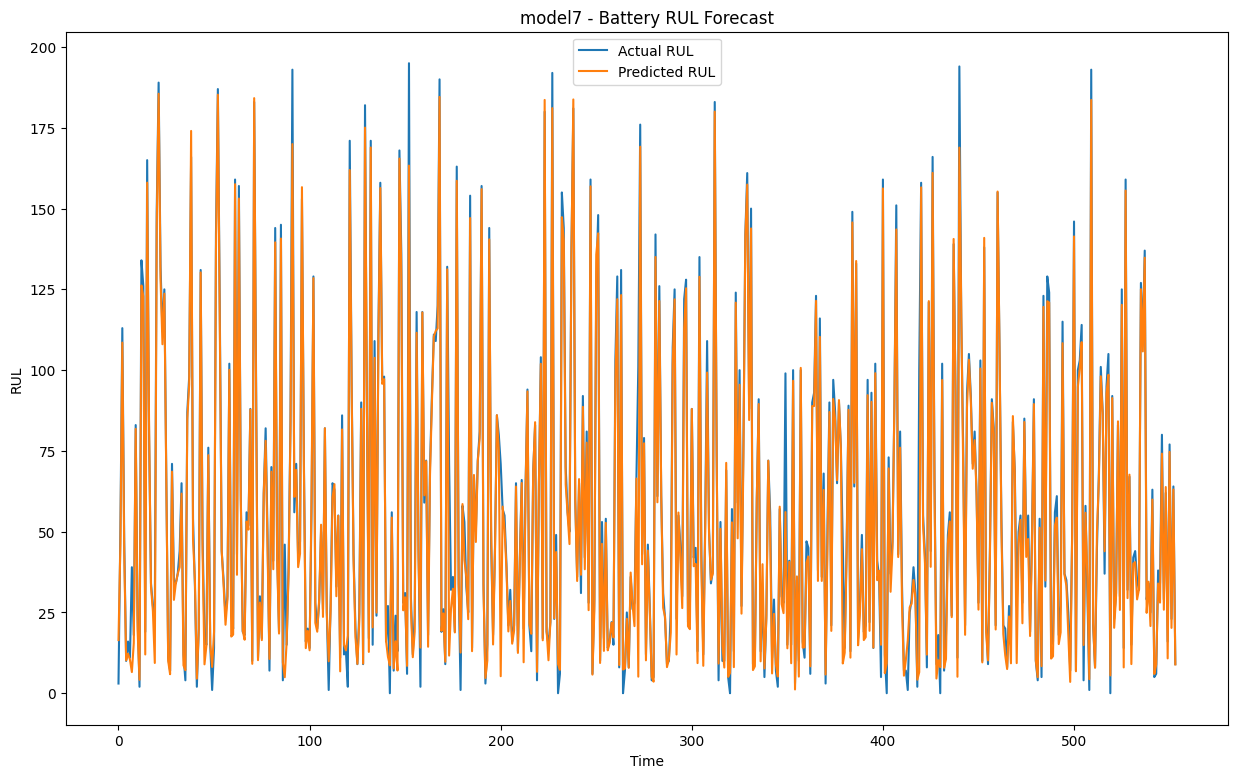

In [ ]:
forecast_rul(model7, x_test, y_test, 'model7')

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


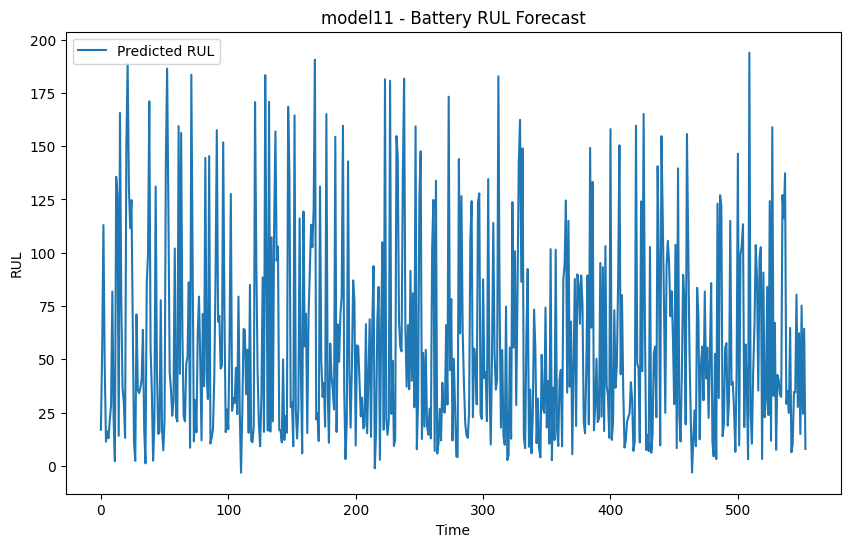

In [ ]:
title = "model11"
y_pred = model11.predict(x_test).flatten()

plt.figure(figsize=(10, 6))
#plt.plot(y_test, label='Actual RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.title(f'{title} - Battery RUL Forecast')
plt.xlabel('Time')
plt.ylabel('RUL')
plt.legend()
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


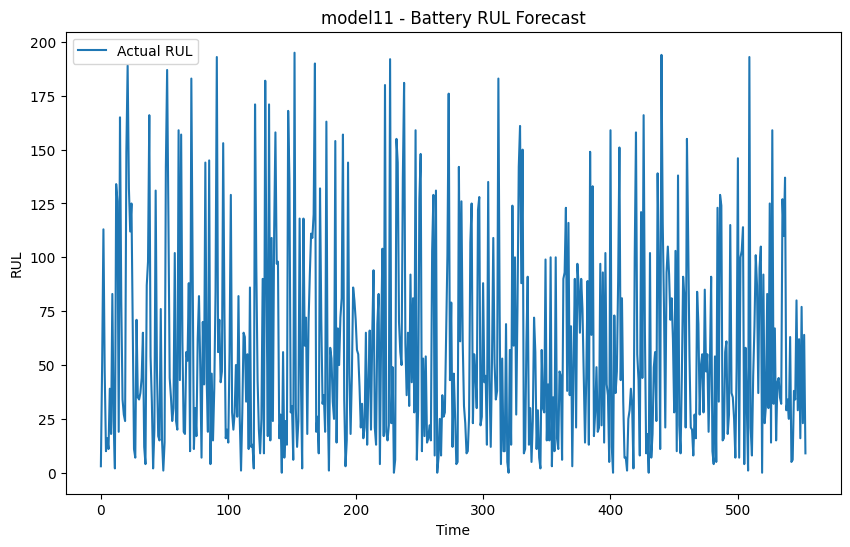

In [ ]:
title = "model11"
y_pred = model11.predict(x_test).flatten()

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual RUL')
#plt.plot(y_pred, label='Predicted RUL')
plt.title(f'{title} - Battery RUL Forecast')
plt.xlabel('Time')
plt.ylabel('RUL')
plt.legend()
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


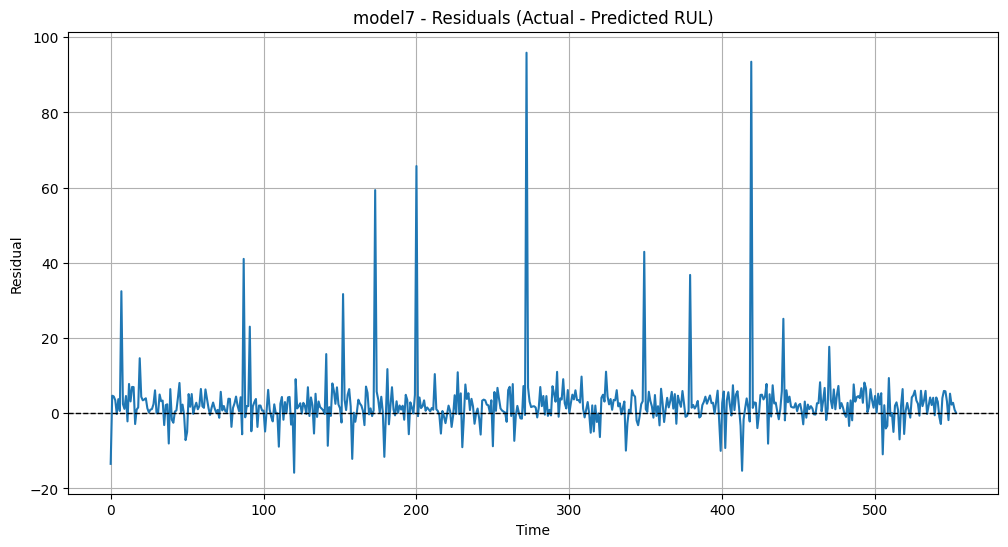

In [ ]:
title = "model7"
y_pred = model7.predict(x_test).flatten()

# Calculate residuals
residuals = y_test - y_pred

plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.axhline(0, color='k', linestyle='--', linewidth=1) # Add a horizontal line at 0
plt.title(f'{title} - Residuals (Actual - Predicted RUL)')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.grid(True)
plt.show()